In [14]:

#imports
import numpy as np
import pandas as pd
import math
import pickle
import os
import ast
import string
import scipy.stats as stats
#no warnings
import warnings
warnings.filterwarnings('ignore')
import json

In [15]:
#first, get list of participants that are in the study, from xls file 

path_excel = '../data/ParticipantLog.xlsx'

df = pd.read_excel(path_excel, sheet_name='ParticipantLog')

participant_list = []
for ind,row in df.iterrows():
    if row['USE?'] in ['Y','M']:
        participant_list.append(row['participant_id'])
    #print(row['participant_id'], row['USE?'])

print(len(participant_list))
#participant_list

54


In [16]:
#get session list, by joining every 2 participants in a single string
session_list = []
for i in range(0,len(participant_list),2):
    session_list.append(str(participant_list[i])+str(participant_list[i+1]))
print(len(session_list))
#session_list

27


# get vad files per session, merge with openface and opensmile

In [17]:
#first, selected features from openface
path_openface = '../data/openface/features_extracted/'
path_opensmile  = '../data/opensmile_feats/'
oface_feats = ['timestamp','confidence','success','gaze_0_x','gaze_0_y','gaze_0_z','gaze_1_x','gaze_1_y','gaze_1_z','gaze_angle_x','gaze_angle_y',
               'pose_Tx', 'pose_Ty', 'pose_Tz','pose_Rx', 'pose_Ry', 'pose_Rz', 'AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r','AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r',
               'AU01_c','AU02_c','AU04_c','AU05_c','AU06_c','AU07_c','AU09_c','AU10_c','AU12_c','AU14_c','AU15_c','AU17_c','AU20_c','AU23_c','AU25_c','AU26_c','AU28_c','AU45_c']
osmile_feats = ['start', 'end', 'F0final_sma', 'voicingFinalUnclipped_sma', 'jitterLocal_sma', 'jitterDDP_sma', 'shimmerLocal_sma', 'logHNR_sma', 'audspec_lengthL1norm_sma', 'audspecRasta_lengthL1norm_sma', 'pcm_RMSenergy_sma', 
                'pcm_zcr_sma', 'audSpec_Rfilt_sma[0]', 'audSpec_Rfilt_sma[1]', 'audSpec_Rfilt_sma[2]', 'audSpec_Rfilt_sma[3]', 'audSpec_Rfilt_sma[4]', 'audSpec_Rfilt_sma[5]', 'audSpec_Rfilt_sma[6]', 'audSpec_Rfilt_sma[7]', 
                'audSpec_Rfilt_sma[8]', 'audSpec_Rfilt_sma[9]', 'audSpec_Rfilt_sma[10]', 'audSpec_Rfilt_sma[11]', 'audSpec_Rfilt_sma[12]', 'audSpec_Rfilt_sma[13]', 'audSpec_Rfilt_sma[14]', 'audSpec_Rfilt_sma[15]', 'audSpec_Rfilt_sma[16]', 
                'audSpec_Rfilt_sma[17]', 'audSpec_Rfilt_sma[18]', 'audSpec_Rfilt_sma[19]', 'audSpec_Rfilt_sma[20]', 'audSpec_Rfilt_sma[21]', 'audSpec_Rfilt_sma[22]', 'audSpec_Rfilt_sma[23]', 'audSpec_Rfilt_sma[24]', 'audSpec_Rfilt_sma[25]', 
                'pcm_fftMag_fband250-650_sma', 'pcm_fftMag_fband1000-4000_sma', 'pcm_fftMag_spectralRollOff25.0_sma', 'pcm_fftMag_spectralRollOff50.0_sma', 'pcm_fftMag_spectralRollOff75.0_sma', 'pcm_fftMag_spectralRollOff90.0_sma', 
                'pcm_fftMag_spectralFlux_sma', 'pcm_fftMag_spectralCentroid_sma', 'pcm_fftMag_spectralEntropy_sma', 'pcm_fftMag_spectralVariance_sma', 'pcm_fftMag_spectralSkewness_sma', 'pcm_fftMag_spectralKurtosis_sma', 
                'pcm_fftMag_spectralSlope_sma', 'pcm_fftMag_psySharpness_sma', 'pcm_fftMag_spectralHarmonicity_sma', 'mfcc_sma[1]', 'mfcc_sma[2]', 'mfcc_sma[3]', 'mfcc_sma[4]', 'mfcc_sma[5]', 'mfcc_sma[6]', 'mfcc_sma[7]', 
                'mfcc_sma[8]', 'mfcc_sma[9]', 'mfcc_sma[10]', 'mfcc_sma[11]', 'mfcc_sma[12]', 'mfcc_sma[13]', 'mfcc_sma[14]']




### checking confidence scores for openface

In [7]:
#make new folder in featureextraction folder, called merged_feats
path_merged = '../data/merged_feats/'  
path_openface = '../data/openface/features_extracted/'
path_opensmile  = '../data/opensmile_feats/'
if not os.path.exists(path_merged):
    os.mkdir(path_merged)

#now, open vad files for each participant
database = '../data/vad_logs/'
dataconvs = os.listdir(database)

#database for saving participant percentage of frames below 50%
excluded_frames = pd.DataFrame(columns=['session','participant','percentage'])

#session_list = ['1011']

for folder in dataconvs:
    if folder in session_list:

        subf_dir = os.listdir(database + folder)

        log = folder + '_vad.csv'
        path = database + folder + '/' + log
        print(path)
        df = pd.read_csv(path)
        #add session column
        df['session'] = folder


        #now, open openface and opensmile files for each participant
        #openface
        openface_folds = os.listdir(path_openface)
        if len(folder)>4:
            participants = [folder[0:3],folder[3:6]]
        else:
            participants = [folder[0:2],folder[2:4]]
        print(participants) 
        sess_df_openface = pd.DataFrame()

        for participant in participants:
            #find folder
            path_part = path_openface + participant + '/'
            #open csv
            df_openface = pd.read_csv(path_part + participant + '.csv')
            #select only columns of interest
            df_openface = df_openface[oface_feats]
            #now compare timestamps with vad - reduce openface df to only those rows that are in vad,by getting average of columns that are not timestamp
            timestamps_vad = df['timeelapsed'].values

            #print(df_openface.shape, 'BEFORE')
            #df_openface = df_openface[df_openface['confidence']>0.5]
            #print(df_openface.shape, 'AFTER')

            
            new_df_openface = pd.DataFrame()
            for time in timestamps_vad:
                #print(time)
                #get openface rows between time and last time
                if time == timestamps_vad[0]:
                    new_df_openface = pd.concat([new_df_openface,df_openface[df_openface['timestamp']<=time]])
                    last_time = time
                else:
                    temp_openface = df_openface[(df_openface['timestamp']<=time) & (df_openface['timestamp']>last_time)]
                    #print(temp_openface['timestamp'].values[-1])
                    if len(temp_openface)>0:
                        #get average of columns that are not timestamp, except confidence and success, and get max of colunm with "_c" in it
                        for column in temp_openface.columns:
                            if "_c" in column:
                                temp_openface[column] = temp_openface[column].max()
                            elif column not in ['timestamp','confidence','success']:
                                temp_openface[column] = temp_openface[column].mean()
                            if 'timestamp' in column:
                                temp_openface[column] = time
                        #add temp_openface to new_df_openface as a row
                        new_df_openface = pd.concat([new_df_openface.T,temp_openface.iloc[0,:]], axis=1).T
                    else:
                        print('uh oh')
                        print(time, last_time)
                    last_time = time
            print(new_df_openface.shape)

            #now, check the confidence scores for each row -- if they are under 70%, remove them an print the percentage of rows removed
            print(new_df_openface.shape, 'CHECKING CONFIDENCE FOR PARTICIPANT', participant, '...')
            #temp_df_openface = new_df_openface.copy()
            temp_df_openface = new_df_openface[new_df_openface['confidence']>0.7]
            print(new_df_openface.shape, temp_df_openface.shape)
            print('Percentage of rows removed:', (new_df_openface.shape[0]-temp_df_openface.shape[0])/new_df_openface.shape[0])
            excluded_frames = pd.concat([excluded_frames,pd.DataFrame({'session':folder,'participant':participant,'percentage':(new_df_openface.shape[0]-temp_df_openface.shape[0])/new_df_openface.shape[0]},index=[0])])

    excluded_frames

../data/vad_logs/1011/1011_vad.csv
['10', '11']
(842, 52)
(842, 52) CHECKING CONFIDENCE FOR PARTICIPANT 10 ...
(842, 52) (838, 52)
Percentage of rows removed: 0.004750593824228029
(842, 52)
(842, 52) CHECKING CONFIDENCE FOR PARTICIPANT 11 ...
(842, 52) (684, 52)
Percentage of rows removed: 0.1876484560570071
../data/vad_logs/104105/104105_vad.csv
['104', '105']
(1226, 52)
(1226, 52) CHECKING CONFIDENCE FOR PARTICIPANT 104 ...
(1226, 52) (1226, 52)
Percentage of rows removed: 0.0
(1226, 52)
(1226, 52) CHECKING CONFIDENCE FOR PARTICIPANT 105 ...
(1226, 52) (989, 52)
Percentage of rows removed: 0.1933115823817292
../data/vad_logs/108109/108109_vad.csv
['108', '109']
(1222, 52)
(1222, 52) CHECKING CONFIDENCE FOR PARTICIPANT 108 ...
(1222, 52) (1162, 52)
Percentage of rows removed: 0.049099836333878884
(1222, 52)
(1222, 52) CHECKING CONFIDENCE FOR PARTICIPANT 109 ...
(1222, 52) (1129, 52)
Percentage of rows removed: 0.07610474631751228
../data/vad_logs/112113/112113_vad.csv
['112', '113']
(

In [8]:
excluded_frames

,session,participant,percentage
0,1011,10,0.004751
0,1011,11,0.187648
0,104105,104,0.000000
0,104105,105,0.193312
0,108109,108,0.049100
0,108109,109,0.076105
0,112113,112,0.001637
0,112113,113,0.000000
0,114115,114,0.004926
0,114115,115,0.057471


### running code

In [18]:
#make new folder in featureextraction folder, called merged_feats
path_merged = '../data/merged_feats/'  
path_openface = '../data/openface/features_extracted/'
path_opensmile  = '../data/opensmile_feats/'
if not os.path.exists(path_merged):
    os.mkdir(path_merged)

#now, open vad files for each participant
database = '../data/vad_logs/'
dataconvs = os.listdir(database)

#session_list = ['1011']

for folder in dataconvs:
    if folder in session_list:

        subf_dir = os.listdir(database + folder)

        log = folder + '_vad.csv'
        path = database + folder + '/' + log
        print(path)
        df = pd.read_csv(path)
        #add session column
        df['session'] = folder


        #now, open openface and opensmile files for each participant
        #openface
        openface_folds = os.listdir(path_openface)
        if len(folder)>4:
            participants = [folder[0:3],folder[3:6]]
        else:
            participants = [folder[0:2],folder[2:4]]
        print(participants) 
        sess_df_openface = pd.DataFrame()

        for participant in participants:
            #find folder
            path_part = path_openface + participant + '/'
            #open csv
            df_openface = pd.read_csv(path_part + participant + '.csv')
            #select only columns of interest
            df_openface = df_openface[oface_feats]
            #now compare timestamps with vad - reduce openface df to only those rows that are in vad,by getting average of columns that are not timestamp
            timestamps_vad = df['timeelapsed'].values
            
            new_df_openface = pd.DataFrame()
            for time in timestamps_vad:
                #print(time)
                #get openface rows between time and last time
                if time == timestamps_vad[0]:
                    new_df_openface = pd.concat([new_df_openface,df_openface[df_openface['timestamp']<=time]])
                    last_time = time
                else:
                    temp_openface = df_openface[(df_openface['timestamp']<=time) & (df_openface['timestamp']>last_time)]
                    #print(temp_openface['timestamp'].values[-1])
                    if len(temp_openface)>0:
                        #get average of columns that are not timestamp, except confidence and success, and get max of colunm with "_c" in it
                        for column in temp_openface.columns:
                            if "_c" in column:
                                temp_openface[column] = temp_openface[column].max()
                            elif column not in ['timestamp','confidence','success']:
                                temp_openface[column] = temp_openface[column].mean()
                            if 'timestamp' in column:
                                temp_openface[column] = time
                        #add temp_openface to new_df_openface as a row
                        new_df_openface = pd.concat([new_df_openface.T,temp_openface.iloc[0,:]], axis=1).T
                    else:
                        print('uh oh')
                    last_time = time
            print(new_df_openface.shape)

            #now, check the confidence scores for each row -- if they are under 70%, remove them an print the percentage of rows removed
            print(new_df_openface.shape, 'CHECKING CONFIDENCE FOR PARTICIPANT', participant, '...')
            #temp_df_openface = new_df_openface.copy()
            temp_df_openface = new_df_openface[new_df_openface['confidence']>0.7]
            print(new_df_openface.shape, temp_df_openface.shape)
            print('Percentage of rows removed:', (new_df_openface.shape[0]-temp_df_openface.shape[0])/new_df_openface.shape[0])



            #add "_p0" to all columns except timestamp, confidence, success
            for column in new_df_openface.columns:
                if participant == participants[0]:
                    new_df_openface.rename(columns={column:column+'_p0'}, inplace=True)
                else:
                    new_df_openface.rename(columns={column:column+'_p1'}, inplace=True)
            #reindex
            new_df_openface.reset_index(drop=True, inplace=True)
            #add openface df to session df, horizontally, by timestamp (merge horizontally, adding columns, for rows with same timestamp)
            
            sess_df_openface = pd.concat([sess_df_openface,new_df_openface], axis=1)
            print(sess_df_openface.shape)
            
        #now, remove timestamp, confidence, success columns from sess_df_openface
        sess_df_openface.drop(columns=['timestamp_p0','timestamp_p1','confidence_p0','confidence_p1','success_p0','success_p1'], inplace=True)
        print(sess_df_openface.shape)

        #now, add the sess df to the vad df, horizontally, by timestamp (merge horizontally, adding columns, for rows with same timestamp)
        print(df.shape)
        df = pd.concat([df,sess_df_openface], axis=1)
        print(df.shape)

        #now, open opensmile files for each participant
        #opensmile
        sess_df_opensmile = pd.DataFrame()
        opensmile_folds = os.listdir(path_opensmile)
        #print('FILES IN FOLDER', opensmile_folds)

        for file in opensmile_folds:
            for participant in participants:
                if '_'+participant+'.' in file and '#' not in file:
                    #open csv
                    df_opensmile = pd.read_csv(path_opensmile + file)
                    print(df_opensmile.shape)
                    #select only columns of interest
                    df_opensmile = df_opensmile[osmile_feats]
                    #get timestamp column, by changing the "start" column from format 00:00:00.000 (hours, minutes, seconds) to seconds
                    df_opensmile['timestamp'] = df_opensmile['start'].apply(lambda x: sum([a*b for a,b in zip(map(float,x.split(':')), [3600, 60, 1])]))
                    #print(df_opensmile['timestamp'].values)
                    #print(df_opensmile['start'].values)

                    #now compare timestamps with vad - reduce opensmile df to only those rows that are in vad,by getting average of columns that are not timestamp
                    timestamps_vad = df['timeelapsed'].values
                    new_df_opensmile = pd.DataFrame()

                    last_time = 0
                    for time in timestamps_vad:
                        #print(time)
                        #get opensmile rows between time and last time
                        if time == timestamps_vad[0]:
                            new_df_opensmile = pd.concat([new_df_opensmile,df_opensmile[df_opensmile['timestamp']<=time]])
                            last_time = time
                        else:
                            temp_opensmile = df_opensmile[(df_opensmile['timestamp']<=time) & (df_opensmile['timestamp']>last_time)]
                            #print(temp_opensmile['timestamp'].values[-1])
                            if len(temp_opensmile)>0:
                                #get average of columns that are not timestamp, except confidence and success, and get max of colunm with "_c" in it
                                for column in temp_opensmile.columns:
                                    if column not in ['timestamp','start','end']:
                                        temp_opensmile[column] = temp_opensmile[column].mean()
                                    if 'timestamp' in column:
                                        temp_opensmile[column] = time
                                #add temp_opensmile to new_df_opensmile as a row
                                new_df_opensmile = pd.concat([new_df_opensmile.T,temp_opensmile.iloc[0,:]], axis=1).T
                            else:
                                print('uh oh')
                            last_time = time
                    print(new_df_opensmile.shape)
                    #add "_p0" to all columns except timestamp, start,end
                    for column in new_df_opensmile.columns:
                        if participant == participants[0]:
                            new_df_opensmile.rename(columns={column:column+'_p0'}, inplace=True)
                        else:
                            new_df_opensmile.rename(columns={column:column+'_p1'}, inplace=True)
                    #reindex    
                    new_df_opensmile.reset_index(drop=True, inplace=True)
                    #add opensmile df to session df, horizontally, by timestamp (merge horizontally, adding columns, for rows with same timestamp)
                    sess_df_opensmile = pd.concat([sess_df_opensmile,new_df_opensmile], axis=1)
                    print(sess_df_opensmile.shape)
        #now, remove timestamp, start, end columns from sess_df_opensmile
        sess_df_opensmile.drop(columns=['timestamp_p0','timestamp_p1','start_p0','start_p1','end_p0','end_p1'], inplace=True)
        print(sess_df_opensmile.shape)

        #now, add the sess df to the vad df, horizontally, by timestamp (merge horizontally, adding columns, for rows with same timestamp)
        print(df.shape)
        df = pd.concat([df,sess_df_opensmile], axis=1)
        print(df.shape)

        #now, save the merged df as a csv
        df.to_csv(path_merged + folder + '_merged.csv', index=False)
        



../data/vad_logs/1011/1011_vad.csv
['10', '11']
(842, 52)
(842, 52) CHECKING CONFIDENCE FOR PARTICIPANT 10 ...
(842, 52) (838, 52)
Percentage of rows removed: 0.004750593824228029
(842, 52)
(842, 52)
(842, 52) CHECKING CONFIDENCE FOR PARTICIPANT 11 ...
(842, 52) (684, 52)
Percentage of rows removed: 0.1876484560570071
(842, 104)
(842, 98)
(842, 9)
(842, 107)
(42180, 67)
(842, 68)
(842, 68)
(42132, 67)
(842, 68)
(842, 136)
(842, 130)
(842, 107)
(842, 237)
../data/vad_logs/104105/104105_vad.csv
['104', '105']
(1226, 52)
(1226, 52) CHECKING CONFIDENCE FOR PARTICIPANT 104 ...
(1226, 52) (1226, 52)
Percentage of rows removed: 0.0
(1226, 52)
(1226, 52)
(1226, 52) CHECKING CONFIDENCE FOR PARTICIPANT 105 ...
(1226, 52) (989, 52)
Percentage of rows removed: 0.1933115823817292
(1226, 104)
(1226, 98)
(1226, 9)
(1226, 107)
(61388, 67)
(1226, 68)
(1226, 68)
(61383, 67)
(1226, 68)
(1226, 136)
(1226, 130)
(1226, 107)
(1226, 237)
../data/vad_logs/108109/108109_vad.csv
['108', '109']
(1222, 52)
(1222, 

KeyboardInterrupt: 

In [ ]:
df

,globaltime,timeintervals,left_speech_active,right_speech_active,talking_now,talking_before,logtype,timeelapsed,session,gaze_0_x_p0,...,mfcc_sma[5]_p1,mfcc_sma[6]_p1,mfcc_sma[7]_p1,mfcc_sma[8]_p1,mfcc_sma[9]_p1,mfcc_sma[10]_p1,mfcc_sma[11]_p1,mfcc_sma[12]_p1,mfcc_sma[13]_p1,mfcc_sma[14]_p1
0,1.686019e+09,0.000000,False,False,False,NaN,Log_Type.TALKER,0.000000,104105,0.143103,...,-0.88127,0.656767,4.205605,3.610532,1.75369,-0.132185,1.978551,-7.252219,3.370281,7.801273
1,1.686019e+09,0.500607,False,False,NaN,NaN,Log_Type.TALKER,0.500759,104105,0.060014,...,1.654741,1.203728,1.574011,-0.92546,1.493502,-1.539803,1.29665,-0.384518,-0.992056,-2.53053
2,1.686019e+09,0.500674,False,False,NaN,NaN,Log_Type.TALKER,1.001697,104105,0.155020,...,1.214365,0.763186,2.088404,-1.545111,0.467106,1.074788,-0.543279,0.763379,0.83945,-0.711338
3,1.686019e+09,0.500705,False,False,NaN,NaN,Log_Type.TALKER,1.502661,104105,0.152480,...,4.098671,2.108947,0.889015,-0.246972,1.725273,1.456516,2.409721,-1.695411,2.635303,1.239365
4,1.686019e+09,0.500618,False,False,NaN,NaN,Log_Type.TALKER,2.003602,104105,0.153846,...,2.763771,4.188392,0.951608,-4.373275,-4.383483,1.758424,4.648342,-3.344603,-2.109952,-1.6899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,1.686019e+09,0.500686,False,False,NaN,NaN,Log_Type.TALKER,611.568111,104105,-0.019306,...,0.338733,-0.57696,-0.606119,-0.889873,3.250148,0.332873,2.23294,0.28059,-0.213643,-0.393226
1222,1.686019e+09,0.500686,False,False,NaN,NaN,Log_Type.TALKER,612.069125,104105,-0.031304,...,2.079572,-0.06008,0.17891,1.844252,-0.523216,0.396814,0.069166,0.431912,2.051365,0.449806
1223,1.686019e+09,0.500810,False,False,NaN,NaN,Log_Type.TALKER,612.570241,104105,0.021767,...,1.156839,0.196028,0.47136,-0.350966,2.636077,0.586303,0.439261,0.26713,0.45379,0.323802
1224,1.686019e+09,0.500399,False,False,NaN,NaN,Log_Type.TALKER,613.071263,104105,0.017436,...,2.666135,2.203144,2.88549,-0.608918,2.460627,0.097208,1.3475,0.184994,1.187481,0.127282


# get jsons again, correct interpolation

In [8]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from scipy.interpolate import interp1d
#import mse
from sklearn.metrics import mean_squared_error
from scipy.signal import medfilt


In [9]:
#one by one, open json files in a folder, read them and add them to pandas dataframe as two columns: 'time' and 'value'

#see files in folder
filelist = os.listdir('../data/ParticipantsJSON/')
filelist = [file for file in filelist if file.endswith('.json')]

#make empty dataframe
df = pd.DataFrame(columns=['participant_number','session','timestamp', 'frame_number','frame_seconds','seconds', 'value'], index=(range(len(participant_list))))
dfrow = 0
#open files one by one and read
for file in filelist:
    pnumber = int(file[:-12])
    print(pnumber)
    if pnumber in participant_list:
        
        #session number, knowing it started at 0 and it's 2 participants per session (p number start at 0)
        session = np.ceil((pnumber-1)/2)

        # Opening JSON file
        f = open('../data/ParticipantsJSON/' + file)
        
        # returns JSON object as 
        # a dictionary
        data = json.load(f)
        #print(data)
    
        #adding to pandas df, one column for time==keys and one for values, but a single row
        #get dictionary keys
        keys = list(data.keys())
        #get dictionary values
        values_list = list(data.values())
        print(len(keys))
        values = []
        #turn every value into an int
        for value in values_list:
            value = int(value)
            values.append(value)
            
        if keys[0] == "ID":
            keys = keys[1:]
            values = values[1:]
        frames = []
        seconds = []
        frameseconds = []
        for keyf in keys:
            #split keyf according to ":"
            keyf = keyf.split(":")
            #get frames (last)
            frames.append(int(keyf[-1]))
            frameseconds.append(int(keyf[-1])/25)
            #get seconds (second to last all the way to the first)
            seconds.append(int(keyf[-2]) + 60 * int(keyf[-3]) + 3600 * int(keyf[-4]))

            
        #place in df
        df.loc[dfrow] = [pnumber,session, keys, frames,frameseconds,seconds,values]
        dfrow += 1

        # Closing file
        f.close()

df = df.sort_values(by=['participant_number'])
df.index = range(len(df))
#save df as csv
df.to_csv('../data/participant_json.csv', index=False)
df

10
844
11
828
28
683
29
683
44
1233
45
1234
50
1283
51
1283
52
1204
53
1284
54
1231
55
1234
58
1137
59
1137
64
1234
65
1235
98
1220
99
1220
76
962
77
961
78
1219
79
1220
80
1200
81
1201
82
806
83
805
105
1228
112
613
108
1225
114
1225
104
1225
109
1225
115
1225
120
1209
121
1209
122
1180
123
1179
124
1273
125
1273
126
2169
127
1231
130
1152
131
1110
88
933
89
1007
90
1215
91
1213
92
1144
93
1144
96
1257
97
1258
113
612
135
1241
134
1229


,participant_number,session,timestamp,frame_number,frame_seconds,seconds,value
0,10,5.0,"[0:0:0:11, 0:0:0:24, 0:0:1:36, 0:0:1:49, 0:0:2...","[11, 24, 36, 49, 61, 74, 86, 99, 111, 124, 137...","[0.44, 0.96, 1.44, 1.96, 2.44, 2.96, 3.44, 3.9...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,11,5.0,"[0:0:0:8, 0:0:0:21, 0:0:1:34, 0:0:1:46, 0:0:2:...","[8, 21, 34, 46, 59, 72, 85, 98, 111, 123, 136,...","[0.32, 0.84, 1.36, 1.84, 2.36, 2.88, 3.4, 3.92...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1..."
2,28,14.0,"[0:0:0:10, 0:0:0:22, 0:0:1:35, 0:0:1:48, 0:0:2...","[10, 22, 35, 48, 60, 73, 85, 97, 110, 123, 135...","[0.4, 0.88, 1.4, 1.92, 2.4, 2.92, 3.4, 3.88, 4...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, ..."
3,29,14.0,"[0:0:0:9, 0:0:0:20, 0:0:1:33, 0:0:1:45, 0:0:2:...","[9, 20, 33, 45, 58, 70, 83, 97, 108, 120, 133,...","[0.36, 0.8, 1.32, 1.8, 2.32, 2.8, 3.32, 3.88, ...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0, 0, 0, 0, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,44,22.0,"[0:0:0:5, 0:0:0:18, 0:0:1:31, 0:0:1:43, 0:0:2:...","[5, 18, 31, 43, 55, 68, 80, 93, 105, 118, 130,...","[0.2, 0.72, 1.24, 1.72, 2.2, 2.72, 3.2, 3.72, ...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,45,22.0,"[0:0:0:4, 0:0:0:16, 0:0:1:29, 0:0:1:41, 0:0:2:...","[4, 16, 29, 41, 54, 66, 79, 91, 104, 116, 129,...","[0.16, 0.64, 1.16, 1.64, 2.16, 2.64, 3.16, 3.6...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
6,50,25.0,"[0:0:0:9, 0:0:0:21, 0:0:1:34, 0:0:1:46, 0:0:2:...","[9, 21, 34, 46, 59, 72, 84, 96, 109, 121, 134,...","[0.36, 0.84, 1.36, 1.84, 2.36, 2.88, 3.36, 3.8...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 3, 3, 3, ..."
7,51,25.0,"[0:0:0:8, 0:0:0:21, 0:0:1:33, 0:0:1:46, 0:0:2:...","[8, 21, 33, 46, 58, 71, 83, 96, 108, 121, 133,...","[0.32, 0.84, 1.32, 1.84, 2.32, 2.84, 3.32, 3.8...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,52,26.0,"[0:0:0:1, 0:0:0:13, 0:0:1:26, 0:0:1:38, 0:0:2:...","[1, 13, 26, 38, 51, 63, 76, 88, 101, 113, 126,...","[0.04, 0.52, 1.04, 1.52, 2.04, 2.52, 3.04, 3.5...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
9,53,26.0,"[0:0:0:6, 0:0:0:19, 0:0:1:31, 0:0:1:43, 0:0:2:...","[6, 19, 31, 43, 56, 69, 81, 93, 106, 119, 131,...","[0.24, 0.76, 1.24, 1.72, 2.24, 2.76, 3.24, 3.7...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
#for each session, calculate degree of disagreement between participants with a scale of 0.1 seconds

#create new df with columns: session, participant, frame_seconds, value
df_interp = pd.DataFrame(columns=['session','participant_number','frame_seconds','value'], index=range(len(df)))

#first, get session df
sessions = df['session'].unique()
for session in sessions:
    df_session = df[df['session']==session]
    #get all participants
    participants = df_session['participant_number'].unique()
    #per participant, get all frame_seconds
    for participant in participants:
        df_p = df_session[df_session['participant_number']==participant]
  
        frame_seconds = df_p['frame_seconds'].values[0]
        values = df_p['value'].values[0]
        #now, interpolate both arrays to have the frames_seconds as the same at a 0.1 second interval
        #get min and max frame_seconds
        min_frame_seconds = min(frame_seconds)
        max_frame_seconds = np.round(max(frame_seconds),1) 
    
        
        #create new frame_seconds array
        new_frame_seconds = np.arange(0.0,max_frame_seconds,0.5) #changed from 0.1 to 0.5

        print(participant,min_frame_seconds,max_frame_seconds,len(new_frame_seconds),len(frame_seconds))
    
        #interpolate values (step interpolation)
        #Create the interpolation function
        f = interp1d(frame_seconds, values, kind='next',fill_value='extrapolate')
        # Use the interpolation function to get the corresponding y-values
        new_values = f(new_frame_seconds)

        #print('new_session')
        #print(len(new_frame_seconds),len(new_values))
        #print(len(frame_seconds),len(values))
        
        #add to new df
        df_interp.loc[df_p.index] = [session,participant,new_frame_seconds,new_values]

    #print(df_interp.head())

    #just to check interpolation:
    ##plot for one partipant, then plot the other in the session
    #plt.figure(figsize=(10,5))
    ##plot from values in df_interp
    #for p in [participant -1, participant]:
    #    df_p = df_interp[df_interp['participant_number']==p]
    #    x = np.array(df_p['frame_seconds'].values[0])
    #    y = np.array(df_p['value'].values[0])
    #    plt.plot(x,y,label = 'Participant ' + str(p))
    #    #also plot the original values
    #    df_p = df_session[df_session['participant_number']==p]
    #    x = np.array(df_p['frame_seconds'].values[0])
    #    y = np.array(df_p['value'].values[0])
    #    plt.plot(x,y,label = 'Participant ' + str(p) + ' original')

    #plt.title('Session ' + str(session))
    #plt.legend()
    #plt.xlabel('Frame seconds')
    #plt.ylabel('Value')
    #plt.show()

deltas = []
delta_signs = []
cumsums = []
deltacumsum = []
    
#go back to df_interp, session by session, and make the frames_seconds be the same for all participants (equal to the max length of the frames_seconds array)
#and then extrapolate the values as per the last value
sessions = df_interp['session'].unique()
for session in sessions:
    df_session = df_interp[df_interp['session']==session]
    
    #get max length of frames_seconds
    max_length = max([len(x) for x in df_session['frame_seconds'].values])
    max_time = max([max(x) for x in df_session['frame_seconds'].values])
    min_time = min([min(x) for x in df_session['frame_seconds'].values])
   
    #get all participants
    participants = df_session['participant_number'].unique()
    #per participant, get all frame_seconds
    for participant in participants:
        old_frame = df_session[df_session['participant_number']==participant]['frame_seconds'].values[0]
        old_values = df_session[df_session['participant_number']==participant]['value'].values[0]
        #create new frame_seconds array
        new_frame_seconds = np.arange(0.0,max_time+0.5,0.5)[:max_length] #CHANGERD FROM 0.1 to 0.5
        #print('participant 1 ', max_time, np.array_equal(new_frame_seconds,old_frame))
        #if needed, extend old_values to have the same length as new_frame_seconds, by the last value
        if len(old_frame) < max_length:
            old_values = np.append(old_values,[old_values[-1]]*(max_length-len(old_frame)))
        #replace in df_interp
        df_interp.loc[df_session[df_session['participant_number']==participant].index] = [session,participant,new_frame_seconds,old_values]
        print('interp')
        print(old_frame.shape,new_frame_seconds.shape,old_values.shape)

    #add information about the derivative of the values
    #get all participants

    df_session = df_interp[df_interp['session']==session]
    participants = df_session['participant_number'].unique()
    
    #per participant, get all frame_seconds
    for participant in participants:
        print(participant)
        old_frame = df_session[df_session['participant_number']==participant]['frame_seconds'].values[0]
        old_values = df_session[df_session['participant_number']==participant]['value'].values[0]
        #calculate delta between every to consequentent values
        delta_values = np.diff(old_values)
        deltas.append(delta_values)
        #calculate how derivative changes over time - if positive,1, if negative, -1, if 0, 0
        delta_sign = np.sign(delta_values)
        delta_signs.append(delta_sign)

        #calculate cumsum
        cumsum_values = np.cumsum(old_values)
        cumsums.append(cumsum_values)
        #calculate values with median filter of size 101 (10 seconds)
        median_values = medfilt(old_values,101)
        deltacumsum.append(median_values)

    


#add to df_interp
df_interp['cumsum'] = cumsums
df_interp['derivative'] = deltas
df_interp['derivative_sign'] = delta_signs
df_interp['medianfilt'] = deltacumsum

#print the range of values in the deltas
delta_signs = np.concatenate(delta_signs)
print('Delta signs:', np.unique(delta_signs))
#print counts
unique, counts = np.unique(delta_signs, return_counts=True)
print('Counts:', dict(zip(unique, counts)))



#save df_interp
df_interp.to_pickle('../df_interpolated5dec.pkl')
#to csv
df_interp.to_csv('../df_interpolated5dec.csv')



10 0.44 421.4 843 843
11 0.32 421.6 844 827
28 0.4 340.9 682 682
29 0.36 340.8 682 682
44 0.2 616.2 1233 1233
45 0.16 616.6 1234 1234
50 0.36 640.8 1282 1282
51 0.32 641.0 1282 1282
52 0.04 600.2 1201 1203
53 0.24 641.2 1283 1283
54 0.24 616.4 1233 1231
55 0.24 616.3 1233 1233
58 0.24 567.7 1136 1136
59 0.2 567.7 1136 1136
64 0.08 616.5 1233 1233
65 0.24 616.8 1234 1234
76 0.48 480.4 961 961
77 0.48 480.3 961 960
78 0.28 609.3 1219 1219
79 0.28 609.3 1219 1219
80 0.44 599.7 1200 1199
81 0.44 599.9 1200 1200
82 0.0 402.3 805 805
83 0.0 402.0 804 804
88 0.2 466.7 934 933
89 0.44 503.1 1007 1006
90 0.0 606.2 1213 1214
91 0.44 606.2 1213 1212
92 0.4 571.4 1143 1143
93 0.08 571.6 1144 1144
96 0.4 628.3 1257 1257
97 0.16 628.1 1257 1257
98 0.28 609.8 1220 1220
99 0.36 609.4 1219 1219
104 0.96 613.9 1228 1224
105 0.44 613.4 1227 1227
108 0.04 611.8 1224 1224
109 0.36 611.8 1224 1224
112 0.16 305.6 612 612
113 0.32 305.8 612 612
114 0.2 611.6 1224 1224
115 0.2 611.7 1224 1224
120 0.36 603.7 12

# open log dfs and process total turns, floorhold, etc

In [11]:
#one by one open merged files
path_merged = '../data/merged_feats/'
merged_files = os.listdir(path_merged)
merged_files = [file for file in merged_files if file.endswith('.csv')]

new_folder = '../data/merged_feats_vad/'
if not os.path.exists(new_folder):
    os.mkdir(new_folder)

for file in merged_files:
    df = pd.read_csv(path_merged + file)

    total_talking_time_p0 = []
    total_number_turns_p0 = []
    total_talking_time_p1 = []
    total_number_turns_p1 = []
    balance_interaction = []
    
    #replace False with "None" in "talking_now" and "talking_before" columns
    df[['talking_now', 'talking_before']] = df[['talking_now', 'talking_before']].replace(False, "None")

    #right is participant with the < number
    #left is participant with the > number
    #get total talking time for each participant, as rows progress
    for ind,row in df.iterrows():
      if ind == 0:
        old_talk_p0 = 0
        old_talk_p1 = 0
      if row['talking_now'] == 'right':
          total_talking_time_p0.append(old_talk_p0 + row['timeintervals'])
          total_talking_time_p1.append(old_talk_p1)
          old_talk_p0 = old_talk_p0 + row['timeintervals']
      elif row['talking_now'] == 'left':
          total_talking_time_p1.append(old_talk_p1 + row['timeintervals'])
          total_talking_time_p0.append(old_talk_p0)
          old_talk_p1 = old_talk_p1 + row['timeintervals']
      else:
          total_talking_time_p0.append(old_talk_p0)
          total_talking_time_p1.append(old_talk_p1)
      total_talking_time_both = old_talk_p0 + old_talk_p1
      if total_talking_time_both == 0:
        floorhold_p0 = 0
        floorhold_p1 = 0
        balance_p0 = 0
        balance_p1 = 0

      else:
        floorhold_p0 = old_talk_p0/total_talking_time_both
        floorhold_p1 = old_talk_p1/total_talking_time_both
        #get balance
        balance_p0 = (floorhold_p0/(floorhold_p0 + floorhold_p1))
        balance_p1 = (floorhold_p1/(floorhold_p0 + floorhold_p1))


      #get imbalance
      imbalance = np.abs(balance_p0 - 0.5) + np.abs(balance_p1 - 0.5)  #from https://dl.acm.org/doi/10.1145/3434074.3447070
      balance_interaction.append(imbalance)
    

          
      
    #print(total_talking_time_p0)
    #cluster df by sequential rows with the same value for "talking_now" (using groupby)

    df_cluster = df.groupby((df['talking_now'] != df['talking_now'].shift()).cumsum()).agg({'globaltime': ['first', 'last'], 'timeelapsed': ['first', 'last'], 'talking_now': ['first'], 'talking_before': ['first']})

    #now, row by row, get the number of turns for each participant, based on each cluster
    #save the speaker, and the globaltime of the first and last row of the cluster
    speaker = []
    globaltime_first = []
    globaltime_last = []
    tot_left = 0
    tot_right = 0
    total_turns_speaker = []
    for ind,row in df_cluster.iterrows():
      speaker.append(row['talking_now']['first'])
      #print(row['talking_now']['first'])
      #add total turns per speaker, based on who's the speaker
      if row['talking_now']['first'] == 'right':
        tot_right += 1
        total_turns_speaker.append(tot_right)
      elif row['talking_now']['first'] == 'left':
        tot_left += 1
        total_turns_speaker.append(tot_left)
      else:
        total_turns_speaker.append(0)
      globaltime_first.append(row['globaltime']['first'])
      globaltime_last.append(row['globaltime']['last'])

      #print(row['globaltime']['first'],row['globaltime']['last'])
    #print(df['globaltime'].values[0],df['globaltime'].values[-1])

    totalturns_p0 = 0
    totalturns_p1 = 0
    #now, go row by row to the merged df, add number of turns as many times as the cluster lasts
    for ind,row in df.iterrows():
      time = row['globaltime']
      #print(time)
      #find the index of the cluster that contains this time
      for i in range(len(globaltime_first)):
        if time >= globaltime_first[i] and time <= globaltime_last[i]:
          
          #add number of turns to df
          if speaker[i] == 'right':
            totalturns_p0 = total_turns_speaker[i]

            total_number_turns_p0.append(totalturns_p0)
            total_number_turns_p1.append(totalturns_p1)
       
          elif speaker[i] == 'left':
            totalturns_p1 = total_turns_speaker[i]
            total_number_turns_p0.append(totalturns_p0)
            total_number_turns_p1.append(totalturns_p1)
          else:
            total_number_turns_p0.append(totalturns_p0)
            total_number_turns_p1.append(totalturns_p1)
        
    #move session column to the beginning
    cols = list(df.columns)
    cols = [cols[8]] + cols[0:8] + cols[9:]
    df = df[cols]
    #print(df.columns)
    #move timeelapsed column to place 2
    cols = list(df.columns)
    cols = [cols[0]] + [cols[8]] + cols[1:8] + cols[9:]
    df = df[cols]
    #print(df.columns)

    #remove some columns
    df = df.drop(columns=['left_speech_active','right_speech_active','talking_before','logtype'])
    

    #add to df in specific column order

    df['total_talking_time_p0'] = total_talking_time_p0
    df['total_talking_time_p1'] = total_talking_time_p1
    df['total_number_turns_p0'] = total_number_turns_p0
    df['total_number_turns_p1'] = total_number_turns_p1
    df['imbalance'] = balance_interaction

    #reorder columns
    cols = list(df.columns)
    cols = cols[0:5] + cols[-5:] + cols[5:-5]
    df = df[cols]
    #print(df.columns)

    df.to_csv(new_folder + file[:-4]+'_vad.csv', index=False)
    
    
    df
    



In [18]:
#right is participant with the < number
#left is participant with the > number

# open jsons and get right precision

In [12]:
#open json csv
path_json = '../df_interpolated5dec.pkl'
df_json = pd.read_pickle(path_json)
df_json


,session,participant_number,frame_seconds,value,cumsum,derivative,derivative_sign,medianfilt
0,5.0,10,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5.0,11,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,14.0,28,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,14.0,29,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 3.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 6.0, 9.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 3.0, ..."
4,22.0,44,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,22.0,45,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,25.0,50,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,25.0,51,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,26.0,52,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,26.0,53,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
#session by session of the merged dfs, get the json data exploded into a new dataframe

new_path_merged = '../data/merged_feats_gt5'
#make dir
if not os.path.exists(new_path_merged):
    os.mkdir(new_path_merged)

path_merged = '../data/merged_feats_vad/'
merged_folds = os.listdir(path_merged)
merged_folds = [file for file in merged_folds if file.endswith('.csv')]
for folder in merged_folds:
    session = folder[:-15]
    print(session)
    if len(session)>4:
        participants = [session[0:3],session[3:6]]
    else:
        participants = [session[0:2],session[2:4]]
    print(participants)
    #open merged csv
    df_merged = pd.read_csv(path_merged + folder)
    #find row corresponding to each participant
    long_json_both = pd.DataFrame()
    for participant in participants:
        long_json = pd.DataFrame()
        df_jsonp = df_json[df_json['participant_number']==int(participant)]
        #convert string of array to array
        #df_jsonp['frame_seconds'] = df_jsonp['frame_seconds'].apply(lambda x: ast.literal_eval(x))
        #df_jsonp['values'] = df_jsonp['values'].apply(lambda x: ast.literal_eval(x))
        #df_jsonp['cumsum'] = df_jsonp['cumsum'].apply(lambda x: ast.literal_eval(x))
        #df_jsonp['derivative'] = df_jsonp['derivative'].apply(lambda x: ast.literal_eval(x))
        #print(df_jsonp)
        #now, explode the rows of the json data - frame_seconds, values, cumsum, derivative
        long_json['timestamp'] = df_jsonp['frame_seconds'].explode().values
        long_json['value'] = df_jsonp['value'].explode().values
        long_json['cumsum'] = df_jsonp['cumsum'].explode().values
        derivatives = df_jsonp['derivative'].explode().values
        #add zero at start
        derivatives = np.insert(derivatives,0,0.0)
        long_json['derivative'] = derivatives
        #now for derivative signs
        derivative_signs = df_jsonp['derivative_sign'].explode().values
        derivative_signs = np.insert(derivative_signs,0,0)
        long_json['derivative_sign'] = derivative_signs
        #print(long_json.shape)
        #add "_p0" to all columns except timestamp
        for column in long_json.columns:
            if participant == participants[0]:
                long_json.rename(columns={column:column+'_p0'}, inplace=True)
            else:
                long_json.rename(columns={column:column+'_p1'}, inplace=True)
        #reindex
        long_json.reset_index(drop=True, inplace=True)
        #add long_json to long_json_both, horizontally, by timestamp (merge horizontally, adding columns, for rows with same timestamp)
        long_json_both = pd.concat([long_json_both,long_json], axis=1)
    #print(long_json_both.head())
    #print latest time
    #print(df_merged['timeelapsed'].values[-1])
    #print(long_json_both['timestamp_p0'].values[-1])
    #now, add the long_json_both to the merged df, horizontally, by timestamp (merge horizontally, adding columns, for rows with same timestamp)
    #you should select first only the rows of the timestamps in the long_json_both that are <= the last timestamp in the merged df
    timestamps_merged = df_merged['timeelapsed'].values
    last_time = 0
    new_undersampled_df = pd.DataFrame(columns=long_json_both.columns)

    for time in timestamps_merged:
        #print(time)
        if time == timestamps_merged[0]:
            small_json = long_json_both[long_json_both['timestamp_p0']<=time]
        else:
            small_json = long_json_both[(long_json_both['timestamp_p0']<=time) & (long_json_both['timestamp_p0']>last_time)]
        last_time = time
        if small_json.shape[0]<1:
            
            print('uh oh')
        else:
            #replace the time with the time in the merged df
            small_json['timestamp_p0'] = time
            small_json['timestamp_p1'] = time
            #add last value of small_json to new_undersampled_df
            new_undersampled_df = pd.concat([new_undersampled_df,small_json.iloc[-1:,:]])
    print(new_undersampled_df.shape)
    #now, remove timestamp columns from new_undersampled_df
    new_undersampled_df.drop(columns=['timestamp_p0','timestamp_p1'], inplace=True)
    print(new_undersampled_df.shape)
    #reindex
    new_undersampled_df.reset_index(drop=True, inplace=True)
    #now, add the new_undersampled_df to the merged df, horizontally, by timestamp (merge horizontally, adding columns, for rows with same timestamp)
    df_merged = pd.concat([df_merged,new_undersampled_df], axis=1)
    print(df_merged.shape) 
    #add column that is difference between value_p0 and value_p1
    df_merged['value_diff'] = np.abs(df_merged['value_p0'] - df_merged['value_p1'])
    #now, sum values
    df_merged['value_sum'] = df_merged['value_p0'] + df_merged['value_p1']
    #add column that is difference between cumsum_p0 and cumsum_p1
    df_merged['cumsum_diff'] = np.abs(df_merged['cumsum_p0'] - df_merged['cumsum_p1'])
    #now, sum cumsums
    df_merged['cumsum_sum'] = df_merged['cumsum_p0'] + df_merged['cumsum_p1']
    #for each value of cumsum_p0 and cumsum_p1, adjust a linear regression and get slope
    slope_p1 = []
    slope_p0 = []
    #fill nan with 0 for cumsum
    df_merged['cumsum_p0'] = df_merged['cumsum_p0'].fillna(0)
    df_merged['cumsum_p1'] = df_merged['cumsum_p1'].fillna(0)
    for ind,row in df_merged.iterrows():
        if ind < 2:
            slope_p1.append(0)
            slope_p0.append(0)
        else:
            #print(row['cumsum_p0'],row['cumsum_p1'])
            datap0 = np.array(df_merged['cumsum_p0'].values[:ind])
            x = np.array(df_merged['timeelapsed'].values[:ind])
            #print(x.shape, datap0.shape)
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,datap0)
            slope_p0.append(slope)
            datap1 = np.array(df_merged['cumsum_p1'].values[:ind])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,datap1)
            slope_p1.append(slope)
        #if ind == df_merged.shape[0]-1:
        #    slope_p1.append(slope_p1[-1])
        #    slope_p0.append(slope_p0[-1])
    df_merged['slope_p0'] = slope_p0
    df_merged['slope_p1'] = slope_p1
    #difference between slopes
    df_merged['slope_diff'] = np.abs(df_merged['slope_p0'] - df_merged['slope_p1'])


    #now, for colum "talking_now", create 2 columns: one that is 1 when right is talking, and one that is 1 when left is talking
    df_merged['vad_p0'] = df_merged['talking_now'].apply(lambda x: 1 if x == 'right' else 0)
    df_merged['vad_p1'] = df_merged['talking_now'].apply(lambda x: 1 if x == 'left' else 0)
    #move these columns to close to talking_now (position 5)
    cols = list(df_merged.columns)
    cols = cols[0:5] + cols[-2:] + cols[5:-2]
    #drop talking ow
    df_merged.drop(columns=['talking_now'], inplace=True)

    #now, change the columns for groundtruth so they are in places 3-onwards
    cols = list(df_merged.columns)
    cols = cols[0:4] + cols[-15:] + cols[4:-15]
    df_merged = df_merged[cols]
    print(cols)

    #now, save the merged df as a csv
    df_merged.to_csv(new_path_merged + '/' + session+ '_merged_gt.csv', index=False)
    





1011
['10', '11']
(842, 10)
(842, 8)
(842, 246)
['session', 'timeelapsed', 'globaltime', 'timeintervals', 'derivative_p0', 'derivative_sign_p0', 'value_p1', 'cumsum_p1', 'derivative_p1', 'derivative_sign_p1', 'value_diff', 'value_sum', 'cumsum_diff', 'cumsum_sum', 'slope_p0', 'slope_p1', 'slope_diff', 'vad_p0', 'vad_p1', 'total_talking_time_p0', 'total_talking_time_p1', 'total_number_turns_p0', 'total_number_turns_p1', 'imbalance', 'gaze_0_x_p0', 'gaze_0_y_p0', 'gaze_0_z_p0', 'gaze_1_x_p0', 'gaze_1_y_p0', 'gaze_1_z_p0', 'gaze_angle_x_p0', 'gaze_angle_y_p0', 'pose_Tx_p0', 'pose_Ty_p0', 'pose_Tz_p0', 'pose_Rx_p0', 'pose_Ry_p0', 'pose_Rz_p0', 'AU01_r_p0', 'AU02_r_p0', 'AU04_r_p0', 'AU05_r_p0', 'AU06_r_p0', 'AU07_r_p0', 'AU09_r_p0', 'AU10_r_p0', 'AU12_r_p0', 'AU14_r_p0', 'AU15_r_p0', 'AU17_r_p0', 'AU20_r_p0', 'AU23_r_p0', 'AU25_r_p0', 'AU26_r_p0', 'AU45_r_p0', 'AU01_c_p0', 'AU02_c_p0', 'AU04_c_p0', 'AU05_c_p0', 'AU06_c_p0', 'AU07_c_p0', 'AU09_c_p0', 'AU10_c_p0', 'AU12_c_p0', 'AU14_c_p0', '

# merge all and rename

In [6]:
#one by one, open merged files
path_merged = '../data/merged_feats_gt5/'
merged_files = os.listdir(path_merged)
merged_files = [file for file in merged_files if file.endswith('.csv')]
#if there is no training folder, make one
if not os.path.exists('../data/training/'):
    os.mkdir('../data/training/')

all_data = pd.DataFrame()

for file in merged_files:
    df = pd.read_csv(path_merged + file)
    df = df.drop(columns=['globaltime','timeintervals', 'cumsum_p0', 'derivative_p0', 
                          'cumsum_p1', 'derivative_p1', 'value_diff', 'value_sum', 'cumsum_diff', 
                          'cumsum_sum', 'slope_p0', 'slope_p1']
                    )
    
    #now, all columns with p0 in the name should come after columns 2, and then be followed by all with p1
    cols = list(df.columns)
    cols_p0 = [col for col in cols if ('_p0' in col) and 'value_p0' not in col]
    cols_p1 = [col for col in cols if ('_p1' in col) and 'value_p1' not in col]
    df['groundtruth'] = df['value_p0']
    #sessio is now session_0
    df['session'] = df['session'].apply(lambda x: str(x) + '_0')
    cols = cols[0:2] + ['groundtruth','value_p0','value_p1','imbalance'] + cols_p0 + cols_p1
    print(cols)
    df = df[cols]
    #now, copy this df, change columns to have p1 first, and then paste it after the original df
    df_p1 = df.copy()
    #session_number is now session_1
    df_p1['session'] = df_p1['session'].apply(lambda x: str(x)[:-1] + '1')
    cols = list(df_p1.columns)
    cols_p0 = [col for col in cols if '_p0' in col and 'value_p0' not in col]
    cols_p1 = [col for col in cols if '_p1' in col and 'value_p1' not in col]
    df_p1['groundtruth'] = df['value_p1']
    cols = cols[0:2] + ['groundtruth','value_p0','value_p1','imbalance'] + cols_p1 + cols_p0
    df_p1 = df_p1[cols]
    print(df.shape)
    #now, add df_p1 to df
    df = pd.concat([df,df_p1], axis=0)
    print(df.shape)

    #now, rename columns - columns from col 4 onwards should be "s" and then a number
    cols = list(df.columns)
    #print(cols)

    #new_cols = cols[0:5] + ['s' + str(i) for i in range(1,len(cols)-4)]
    #df.columns = new_cols
    #print(df.columns)
    #create dictionary with old and new column names
    dict_cols = {}
    for i in range(len(cols)):
        dict_cols[cols[i]] = new_cols[i]
    #save
    with open('../data/training/dict_cols.json', 'w') as fp:
        json.dump(dict_cols, fp)



    #now, concatenate in the full database
    all_data = pd.concat([all_data,df], axis=0)

#remove all the NaN and inf
print(all_data.shape)
all_data = all_data.replace([np.inf, -np.inf], np.nan)
all_data = all_data.dropna()
print(all_data.shape)

#save all_data
all_data.to_csv('../data/training/all_data_05.csv', index=False)

all_data


['session', 'timeelapsed', 'groundtruth', 'value_p0', 'value_p1', 'imbalance', 'derivative_sign_p0', 'vad_p0', 'total_talking_time_p0', 'total_number_turns_p0', 'gaze_0_x_p0', 'gaze_0_y_p0', 'gaze_0_z_p0', 'gaze_1_x_p0', 'gaze_1_y_p0', 'gaze_1_z_p0', 'gaze_angle_x_p0', 'gaze_angle_y_p0', 'pose_Tx_p0', 'pose_Ty_p0', 'pose_Tz_p0', 'pose_Rx_p0', 'pose_Ry_p0', 'pose_Rz_p0', 'AU01_r_p0', 'AU02_r_p0', 'AU04_r_p0', 'AU05_r_p0', 'AU06_r_p0', 'AU07_r_p0', 'AU09_r_p0', 'AU10_r_p0', 'AU12_r_p0', 'AU14_r_p0', 'AU15_r_p0', 'AU17_r_p0', 'AU20_r_p0', 'AU23_r_p0', 'AU25_r_p0', 'AU26_r_p0', 'AU45_r_p0', 'AU01_c_p0', 'AU02_c_p0', 'AU04_c_p0', 'AU05_c_p0', 'AU06_c_p0', 'AU07_c_p0', 'AU09_c_p0', 'AU10_c_p0', 'AU12_c_p0', 'AU14_c_p0', 'AU15_c_p0', 'AU17_c_p0', 'AU20_c_p0', 'AU23_c_p0', 'AU25_c_p0', 'AU26_c_p0', 'AU28_c_p0', 'AU45_c_p0', 'F0final_sma_p0', 'voicingFinalUnclipped_sma_p0', 'jitterLocal_sma_p0', 'jitterDDP_sma_p0', 'shimmerLocal_sma_p0', 'logHNR_sma_p0', 'audspec_lengthL1norm_sma_p0', 'audspecR

,session,timeelapsed,groundtruth,value_p0,value_p1,s1,s2,s3,s4,s5,...,s228,s229,s230,s231,s232,s233,s234,s235,s236,s237
0,1011_0,0.000000,0.0,0.0,0.0,1.000000,0.0,0,0.000000,0,...,-0.949191,0.725129,-0.223319,1.356420,1.128655,-2.149139,-0.360171,-1.220245,-0.775064,-0.953293
1,1011_0,0.500817,0.0,0.0,0.0,1.000000,0.0,0,0.000000,0,...,-1.413546,-1.126653,-6.233436,-4.526811,1.137285,-5.967533,-1.352295,1.261357,-0.271745,-0.531093
2,1011_0,1.001735,0.0,0.0,0.0,1.000000,0.0,0,0.000000,0,...,1.585577,-1.571658,-6.900836,-4.365034,-1.387563,-11.136663,-7.189628,-2.228303,-3.737631,-4.308240
3,1011_0,1.502701,0.0,0.0,0.0,1.000000,0.0,0,0.000000,0,...,0.197286,-2.750605,-5.841283,-2.667349,-0.612591,-10.525390,-1.224724,2.618726,-2.290872,-2.018926
4,1011_0,2.003673,0.0,0.0,0.0,1.000000,0.0,0,0.000000,0,...,-1.059334,-1.100371,-5.456528,-1.127107,-0.042625,-10.158203,1.296092,4.784063,-0.060083,1.366091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,9899_1,607.746209,0.0,1.0,0.0,0.167152,0.0,1,309.429779,37,...,-0.079130,0.069992,-0.033643,0.077388,0.019398,0.078354,0.003283,0.040605,-0.005163,-0.032927
1214,9899_1,608.247179,0.0,1.0,0.0,0.167937,0.0,1,309.930421,37,...,0.144304,-0.064312,-0.149619,0.472577,-0.512193,0.302832,-0.105411,0.043275,-0.106773,0.145175
1215,9899_1,608.747714,0.0,1.0,0.0,0.168721,0.0,1,310.430666,37,...,-0.418618,-0.009893,0.314501,0.401899,-0.001644,0.015735,-0.048787,-0.071675,-0.072712,0.000495
1216,9899_1,609.248394,0.0,1.0,0.0,0.169503,0.0,1,310.930992,37,...,-0.086015,0.021003,-0.045255,0.006619,-0.022242,0.007797,-0.012008,0.012611,-0.006926,0.011001


In [7]:
#check for nan and inf
print(all_data.shape)
print(all_data.isnull().sum())
print(all_data.isin([np.inf, -np.inf]).sum())
#remove all the NaN and inf
all_data = all_data.replace([np.inf, -np.inf], np.nan)
all_data = all_data.dropna()
print(all_data.shape)
#save all_data
all_data.to_csv('../data/training/all_data_05.csv', index=False)

(60808, 242)
session        0
timeelapsed    0
groundtruth    0
value_p0       0
value_p1       0
              ..
s233           0
s234           0
s235           0
s236           0
s237           0
Length: 242, dtype: int64
session        0
timeelapsed    0
groundtruth    0
value_p0       0
value_p1       0
              ..
s233           0
s234           0
s235           0
s236           0
s237           0
Length: 242, dtype: int64
(60808, 242)


In [8]:
#now, normalize it through standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#fit and transform
all_data.iloc[:,5:] = scaler.fit_transform(all_data.iloc[:,5:])

#replace nan and inf
print(all_data.shape)
all_data = all_data.replace([np.inf, -np.inf], np.nan)
all_data = all_data.dropna()
print(all_data.shape)

#save scaler
import joblib
joblib.dump(scaler, '../data/training/scaler.pkl')
all_data.to_csv('../data/training/all_data_05_norm.csv', index=False)
all_data

(60808, 242)
(60808, 242)


,session,timeelapsed,groundtruth,value_p0,value_p1,s1,s2,s3,s4,s5,...,s228,s229,s230,s231,s232,s233,s234,s235,s236,s237
0,1011_0,0.000000,0.0,0.0,0.0,2.616712,-0.018539,-0.894613,-1.393671,-1.389285,...,-0.078569,0.518890,0.229181,0.416207,-0.161988,0.020682,0.184724,0.170749,-0.098089,0.349904
1,1011_0,0.500817,0.0,0.0,0.0,2.616712,-0.018539,-0.894613,-1.393671,-1.389285,...,-0.112056,0.361399,-0.339011,-0.205442,-0.161137,-0.465553,0.056468,0.552464,-0.014055,0.428640
2,1011_0,1.001735,0.0,0.0,0.0,2.616712,-0.018539,-0.894613,-1.393671,-1.389285,...,0.104225,0.323552,-0.402106,-0.188348,-0.409949,-1.123791,-0.698147,0.015691,-0.592722,-0.275762
3,1011_0,1.502701,0.0,0.0,0.0,2.616712,-0.018539,-0.894613,-1.393671,-1.389285,...,0.004109,0.223285,-0.301937,-0.008963,-0.333579,-1.045952,0.072960,0.761251,-0.351170,0.151173
4,1011_0,2.003673,0.0,0.0,0.0,2.616712,-0.018539,-0.894613,-1.393671,-1.389285,...,-0.086512,0.363634,-0.265563,0.153786,-0.277412,-0.999194,0.398836,1.094319,0.021285,0.782447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,9899_1,607.746209,0.0,1.0,0.0,-0.785711,-0.018539,1.117802,1.948393,1.134613,...,-0.015825,0.463172,0.247113,0.281059,-0.271300,0.304331,0.231709,0.364690,0.030454,0.521544
1214,9899_1,608.247179,0.0,1.0,0.0,-0.782501,-0.018539,1.117802,1.953800,1.134613,...,0.000288,0.451750,0.236148,0.322816,-0.323686,0.332917,0.217658,0.365101,0.013489,0.554758
1215,9899_1,608.747714,0.0,1.0,0.0,-0.779300,-0.018539,1.117802,1.959203,1.134613,...,-0.040307,0.456378,0.280026,0.315348,-0.273373,0.296358,0.224978,0.347419,0.019176,0.527776
1216,9899_1,609.248394,0.0,1.0,0.0,-0.776105,-0.018539,1.117802,1.964607,1.134613,...,-0.016322,0.459005,0.246015,0.273581,-0.275403,0.295347,0.229732,0.360384,0.030160,0.529736


In [20]:
dict_cols

{'session': 'session',
 'timeelapsed': 'timeelapsed',
 'groundtruth': 'groundtruth',
 'value_p0': 'value_p0',
 'value_p1': 'value_p1',
 'imbalance': 's1',
 'derivative_sign_p0': 's2',
 'vad_p0': 's3',
 'total_talking_time_p0': 's4',
 'total_number_turns_p0': 's5',
 'gaze_0_x_p0': 's6',
 'gaze_0_y_p0': 's7',
 'gaze_0_z_p0': 's8',
 'gaze_1_x_p0': 's9',
 'gaze_1_y_p0': 's10',
 'gaze_1_z_p0': 's11',
 'gaze_angle_x_p0': 's12',
 'gaze_angle_y_p0': 's13',
 'pose_Tx_p0': 's14',
 'pose_Ty_p0': 's15',
 'pose_Tz_p0': 's16',
 'pose_Rx_p0': 's17',
 'pose_Ry_p0': 's18',
 'pose_Rz_p0': 's19',
 'AU01_r_p0': 's20',
 'AU02_r_p0': 's21',
 'AU04_r_p0': 's22',
 'AU05_r_p0': 's23',
 'AU06_r_p0': 's24',
 'AU07_r_p0': 's25',
 'AU09_r_p0': 's26',
 'AU10_r_p0': 's27',
 'AU12_r_p0': 's28',
 'AU14_r_p0': 's29',
 'AU15_r_p0': 's30',
 'AU17_r_p0': 's31',
 'AU20_r_p0': 's32',
 'AU23_r_p0': 's33',
 'AU25_r_p0': 's34',
 'AU26_r_p0': 's35',
 'AU45_r_p0': 's36',
 'AU01_c_p0': 's37',
 'AU02_c_p0': 's38',
 'AU04_c_p0': 's

In [9]:
# merge all and rename ................FOR DERIVATIVE SIGNS
#one by one, open merged files
path_merged = '../data/merged_feats_gt5/'
merged_files = os.listdir(path_merged)
merged_files = [file for file in merged_files if file.endswith('.csv')]
#if there is no training folder, make one
if not os.path.exists('../data/training/'):
    os.mkdir('../data/training/')

all_data = pd.DataFrame()

for file in merged_files:
    df = pd.read_csv(path_merged + file)
    df = df.drop(columns=['globaltime','timeintervals', 'cumsum_p0', 'derivative_p0', 
                          'cumsum_p1', 'derivative_p1', 'value_diff', 'value_sum', 'cumsum_diff', 
                          'cumsum_sum', 'slope_p0', 'slope_p1']
                    )
    
    #now, all columns with p0 in the name should come after columns 2, and then be followed by all with p1
    cols = list(df.columns)
    cols_p0 = [col for col in cols if ('_p0' in col) and 'derivative_sign_p0' not in col]
    cols_p1 = [col for col in cols if ('_p1' in col) and 'derivative_sign_p1' not in col]
    #change session to session_0
    df['session'] = df['session'].apply(lambda x: str(x) + '_0')
    df['groundtruth'] = df['derivative_sign_p0']
    cols = cols[0:2] + ['groundtruth','derivative_sign_p0','derivative_sign_p1','imbalance'] + cols_p0 + cols_p1
    print(cols)
    df = df[cols]
    #now, copy this df, change columns to have p1 first, and then paste it after the original df
    df_p1 = df.copy()
    #change session to session_1
    df_p1['session'] = df_p1['session'].apply(lambda x: str(x)[:-1] + '1')
    cols = list(df_p1.columns)
    cols_p0 = [col for col in cols if '_p0' in col and 'derivative_sign_p0' not in col]
    cols_p1 = [col for col in cols if '_p1' in col and 'derivative_sign_p1' not in col]
    df_p1['groundtruth'] = df['derivative_sign_p1']
    cols = cols[0:2] + ['groundtruth','derivative_sign_p0','derivative_sign_p1','imbalance'] + cols_p1 + cols_p0
    df_p1 = df_p1[cols]
    print(df.shape)
    #now, add df_p1 to df
    df = pd.concat([df,df_p1], axis=0)
    print(df.shape)

    #now, rename columns - columns from col 4 onwards should be "s" and then a number
    cols = list(df.columns)
    print(cols)

    new_cols = cols[0:5] + ['s' + str(i) for i in range(1,len(cols)-4)]
    df.columns = new_cols
    print(df.columns)
    #create dictionary with old and new column names
    dict_cols = {}
    for i in range(len(cols)):
        dict_cols[cols[i]] = new_cols[i]
    #save
    with open('../data/training/dict_cols_sign.json', 'w') as fp:
        json.dump(dict_cols, fp)



    #now, concatenate in the full database
    all_data = pd.concat([all_data,df], axis=0)

#remove groundtruth = 0 rows

all_data = all_data[all_data['groundtruth']!=0]
#make -1 values be 0 for the groundtruth column
all_data['groundtruth'] = all_data['groundtruth'].replace(-1,0)

print(df.columns)

#remove all the NaN and inf
print(all_data.shape)
all_data = all_data.replace([np.inf, -np.inf], np.nan)
all_data = all_data.dropna()
print(all_data.shape)

#save all_data
all_data.to_csv('../data/training/all_data_05_sign.csv', index=False)



#now, normalize it through standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()



#fit and transform
all_data.iloc[:,5:] = scaler.fit_transform(all_data.iloc[:,5:])

#remove nan
print(all_data.shape)
all_data = all_data.replace([np.inf, -np.inf], np.nan)
all_data = all_data.dropna()
print(all_data.shape)

#save scaler
import joblib
joblib.dump(scaler, '../data/training/scaler_sign.pkl')
all_data.to_csv('../data/training/all_data_05_norm_sign.csv', index=False)
all_data


['session', 'timeelapsed', 'groundtruth', 'derivative_sign_p0', 'derivative_sign_p1', 'imbalance', 'vad_p0', 'total_talking_time_p0', 'total_number_turns_p0', 'gaze_0_x_p0', 'gaze_0_y_p0', 'gaze_0_z_p0', 'gaze_1_x_p0', 'gaze_1_y_p0', 'gaze_1_z_p0', 'gaze_angle_x_p0', 'gaze_angle_y_p0', 'pose_Tx_p0', 'pose_Ty_p0', 'pose_Tz_p0', 'pose_Rx_p0', 'pose_Ry_p0', 'pose_Rz_p0', 'AU01_r_p0', 'AU02_r_p0', 'AU04_r_p0', 'AU05_r_p0', 'AU06_r_p0', 'AU07_r_p0', 'AU09_r_p0', 'AU10_r_p0', 'AU12_r_p0', 'AU14_r_p0', 'AU15_r_p0', 'AU17_r_p0', 'AU20_r_p0', 'AU23_r_p0', 'AU25_r_p0', 'AU26_r_p0', 'AU45_r_p0', 'AU01_c_p0', 'AU02_c_p0', 'AU04_c_p0', 'AU05_c_p0', 'AU06_c_p0', 'AU07_c_p0', 'AU09_c_p0', 'AU10_c_p0', 'AU12_c_p0', 'AU14_c_p0', 'AU15_c_p0', 'AU17_c_p0', 'AU20_c_p0', 'AU23_c_p0', 'AU25_c_p0', 'AU26_c_p0', 'AU28_c_p0', 'AU45_c_p0', 'F0final_sma_p0', 'voicingFinalUnclipped_sma_p0', 'jitterLocal_sma_p0', 'jitterDDP_sma_p0', 'shimmerLocal_sma_p0', 'logHNR_sma_p0', 'audspec_lengthL1norm_sma_p0', 'audspecRas

,session,timeelapsed,groundtruth,derivative_sign_p0,derivative_sign_p1,s1,s2,s3,s4,s5,...,s228,s229,s230,s231,s232,s233,s234,s235,s236,s237
19,1011_0,9.518395,1.0,1.0,0.0,-0.717857,-0.913280,-1.372515,-1.283759,-1.076127,...,0.119956,0.892630,-0.849477,-1.334229,-0.532225,-0.342856,-1.145014,-0.088218,-0.489688,-0.061695
20,1011_0,10.019385,1.0,1.0,0.0,-0.717857,-0.913280,-1.372515,-1.283759,-1.068135,...,-0.709495,0.629000,-2.487800,-0.928256,-0.343150,2.813834,0.007120,1.717392,-0.740496,0.271689
21,1011_0,10.520490,1.0,1.0,0.0,-0.717857,-0.913280,-1.372515,-1.283759,-0.976037,...,-1.581399,1.071574,-0.628717,-2.377479,-0.156368,3.288235,-1.269963,2.109479,-0.349336,-0.052388
25,1011_0,12.525048,1.0,1.0,0.0,0.781017,-0.913280,-1.372515,-1.283759,-0.964925,...,0.495597,0.141628,-0.824649,0.076973,0.574225,-0.574397,-0.192616,0.528994,-0.492486,-0.036710
26,1011_0,13.025722,1.0,1.0,0.0,0.781017,-0.913280,-1.372515,-1.283759,-1.007663,...,0.248928,0.475550,-0.354027,0.091415,0.095609,-1.119003,0.029065,0.402635,0.285542,0.921709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,9899_1,520.568245,0.0,1.0,-1.0,-1.070282,1.094954,1.581202,0.455610,1.193755,...,0.130662,0.227628,-0.385206,0.399270,-0.333497,-0.521119,0.416147,0.650032,-0.511008,0.050461
1073,9899_1,537.602655,1.0,0.0,1.0,-1.028275,1.094954,1.691620,0.584452,0.588018,...,0.024490,0.451220,0.157734,0.204780,-0.133001,0.444969,0.225849,0.373685,-0.007500,0.702717
1075,9899_1,538.604376,1.0,0.0,1.0,-1.020846,1.094954,1.702658,0.584452,0.546919,...,0.026516,0.461521,0.168396,0.210561,-0.147149,0.411770,0.201101,0.369560,-0.021948,0.670068
1095,9899_1,548.626275,0.0,0.0,-1.0,-0.948138,1.094954,1.813088,0.584452,1.214070,...,-0.481711,-0.145036,-0.077716,0.663682,-0.400585,0.100475,-0.772583,-0.424068,0.082998,-0.083074


In [ ]:
#now, one by one, open the dfs and then check label imbalance. plot
dfs = ['all_data_05.csv','all_data_05_norm.csv']

# plots

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from scipy.interpolate import interp1d
#import mse
from sklearn.metrics import mean_squared_error
from scipy.signal import medfilt


In [ ]:
#open df_turns
df_turns = pd.read_csv('../all_merged_df.csv')
#open df_turns_diff
df_turns_diff = pd.read_csv('../df_turns_diff.csv')

In [ ]:
#print participant demographics
#avg age + std
df_turns['age'] = df_turns['age'].astype(float)
print('Average age: ',df_turns['age'].mean(), ' +- ', df_turns['age'].std())
#age range
print('Age range: ',df_turns['age'].min(), ' - ', df_turns['age'].max())
#gender distribution - count occurrences of every value
print( df_turns['gender'].value_counts())
#race distribution
print(df_turns['race'].value_counts())
print(df_turns['proficiency'].value_counts())


Average age:  42.333333333333336  +-  15.787504014848832
Age range:  20.0  -  87.0
Female        28
Male          25
Non-binary     1
Name: gender, dtype: int64
Caucasian/European American/White                                                                                                          38
Hispanic/Latino/Latina/Latinx/Latine                                                                                                        4
Asian/Asian American                                                                                                                        4
African/African American/Black                                                                                                              3
African/African American/Black,Caucasian/European American/White,Hispanic/Latino/Latina/Latinx/Latine                                       1
Caucasian/European American/White,Hispanic/Latino/Latina/Latinx/Latine                                                           

0-0.25:  11
0.25-0.5:  10
0.5-0.75:  6


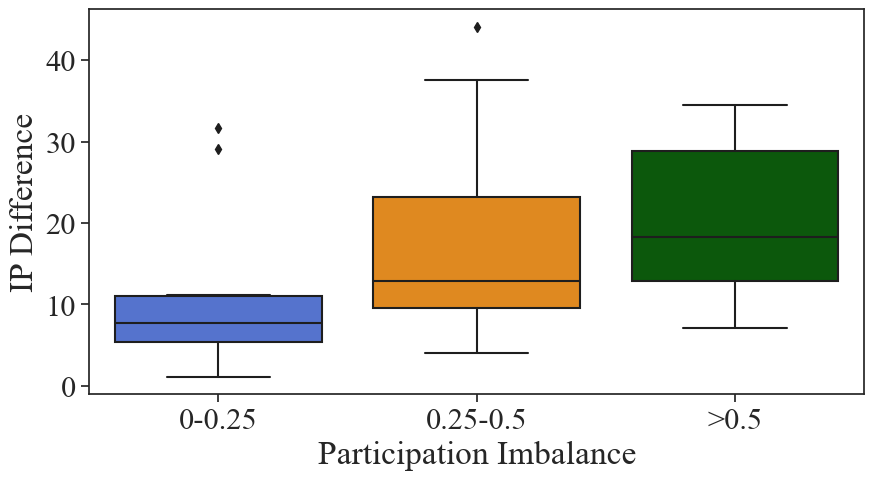

In [ ]:
#plot whisker plots, while grouping by imbalance (0,0.25,0.5,0.75)
#get categories of imbalance, slip into 4 classes

#plot just sessions 41 an 38, as a figure with 4 subplots
import tikzplotlib

sns.set(style="ticks", font_scale=2)
#import itertools
plt.rcParams["font.family"] = "Times New Roman"


colors0 = ['royalblue']#,'mediumblue','cornflowerblue']
colors1 = ['indianred']#,'firebrick']
colors2 = ['darkgreen']#,'forestgreen','limegreen']
colors3 = ['darkorange']#,'goldenrod','gold']

imbalance_cat = []
for ind, row in df_turns_diff.iterrows():
    imb = row['imbalance']
    if imb < 0.25:
        imbalance_cat.append('0-0.25')
    elif imb < 0.5:
        imbalance_cat.append('0.25-0.5')
    else:
        imbalance_cat.append('>0.5')

#print the number of elements in each category
print('0-0.25: ', imbalance_cat.count('0-0.25'))
print('0.25-0.5: ', imbalance_cat.count('0.25-0.5'))
print('0.5-0.75: ', imbalance_cat.count('>0.5'))


#add imbalance_cat to df_turns_diff
df_turns_diff['imbalance_cat'] = imbalance_cat

df_turns_sorted = df_turns_diff.sort_values(by = ['imbalance_cat'])

#create figure
plt.figure(figsize=(10, 5))

#create map with colors0, colors1, colors2 and use in plot
palette = dict(zip(df_turns_sorted['imbalance_cat'].unique(), colors0 + colors3 + colors2))

sns.boxplot(x = 'imbalance_cat', y = 'slope_diff',palette=palette, data = df_turns_sorted)

#plt.title('Slope difference between participants, grouped by imbalance')
plt.xlabel('Participation Imbalance')
plt.ylabel('IP Difference')
plt.savefig('../slope_diff_imbalance.png', dpi = 300, bbox_inches='tight')


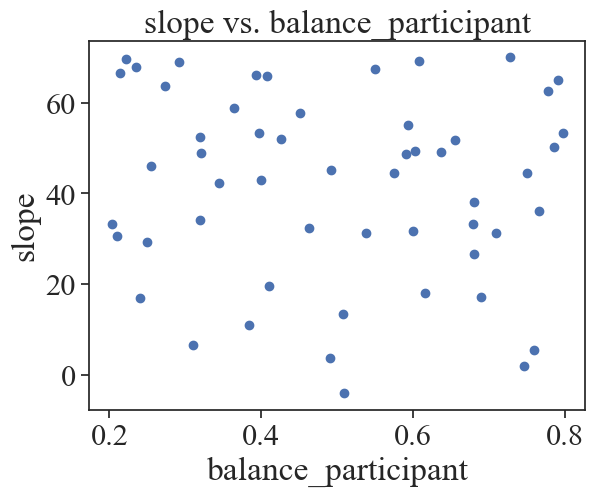

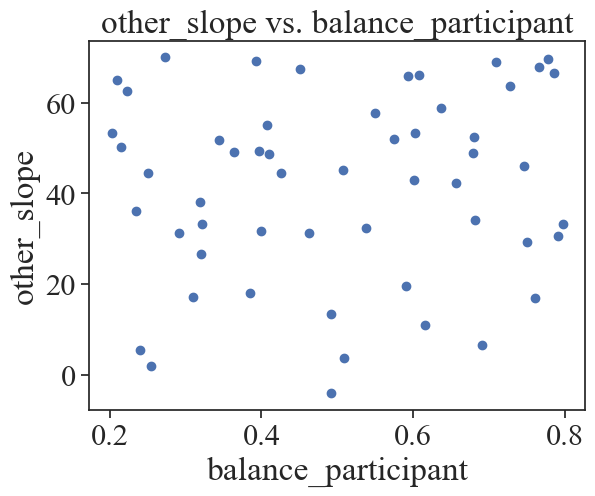

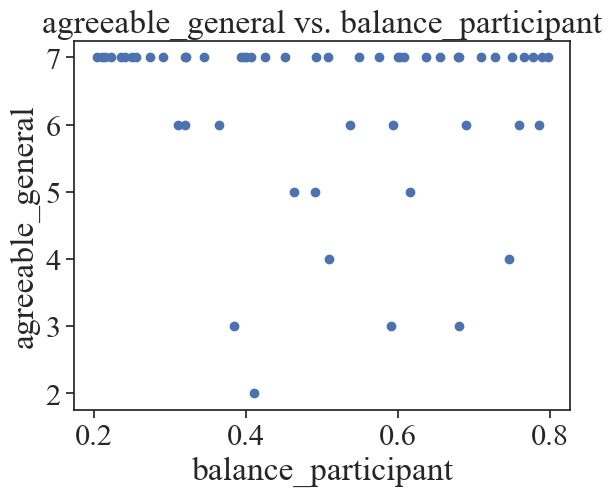

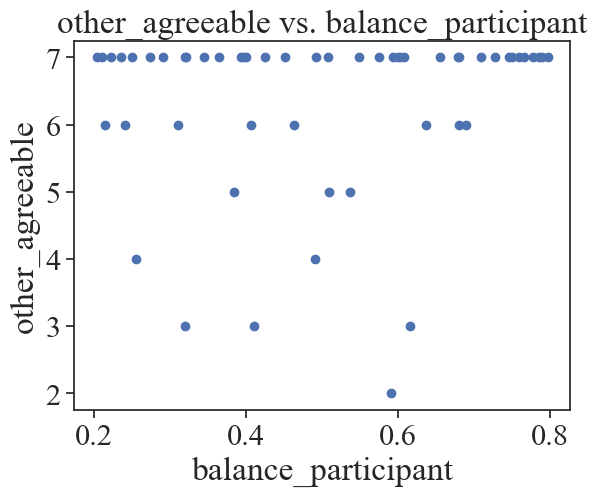

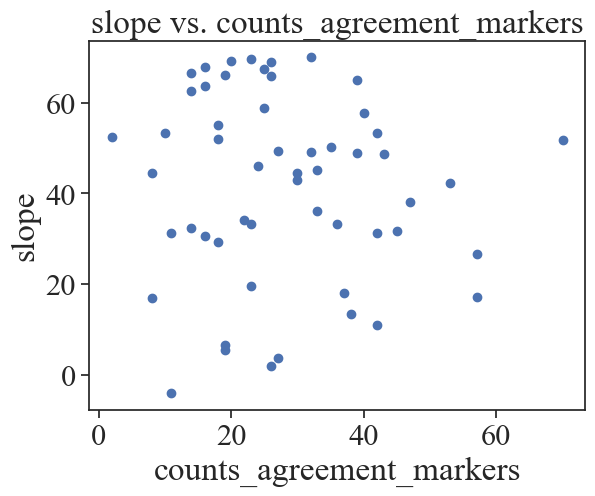

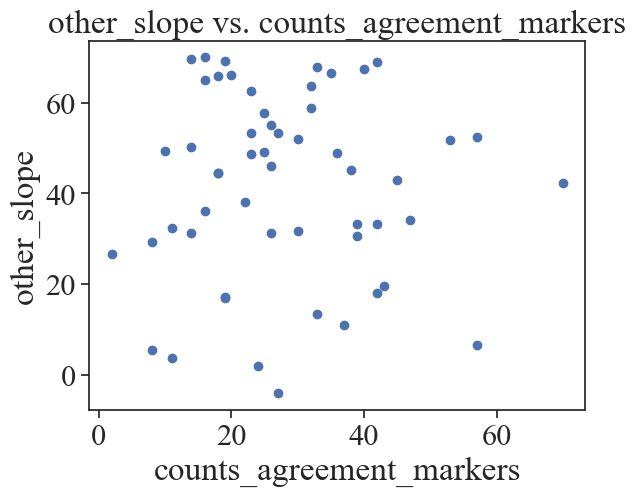

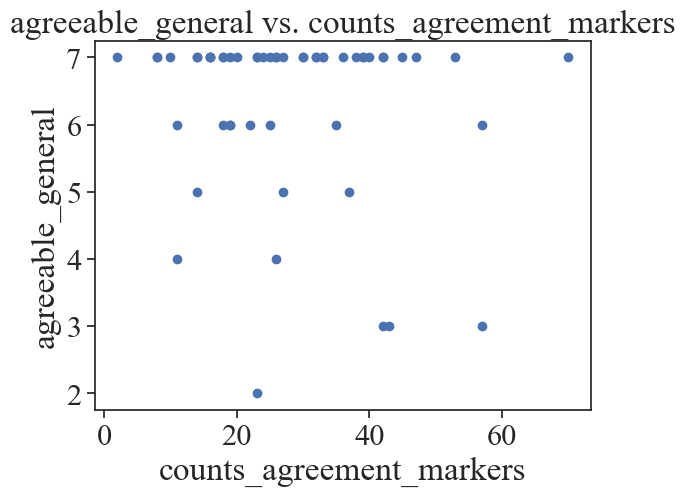

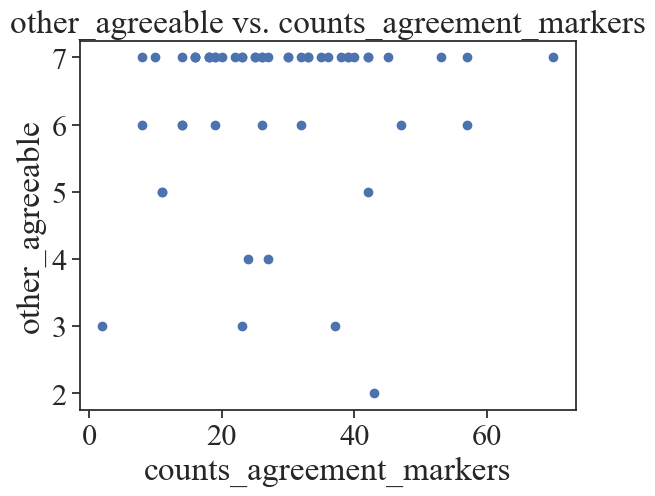

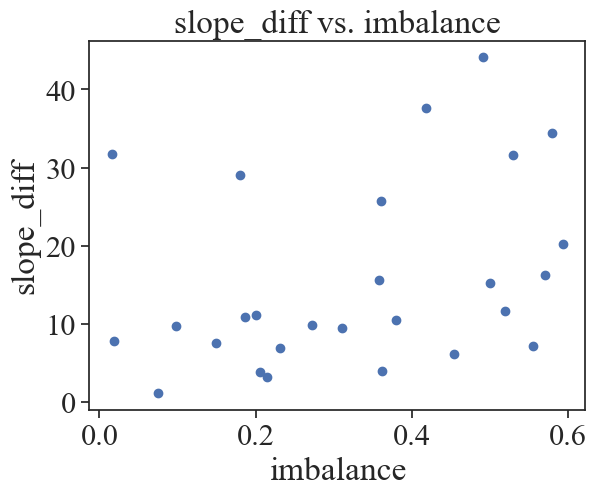

In [ ]:
#plot slope, other_slope, agreeable_general, other_agreeable, vs. balance_participant and vs. counts_agreement_markers, in a scatter plot

#plot slope vs. imbalance
plt.scatter(df_turns['balance_participant'], df_turns['slope'])
plt.xlabel('balance_participant')
plt.ylabel('slope')
plt.title('slope vs. balance_participant')
plt.show()

#plot other_slope vs. balance_participant
plt.scatter(df_turns['balance_participant'], df_turns['other_slope'])
plt.xlabel('balance_participant')
plt.ylabel('other_slope')
plt.title('other_slope vs. balance_participant')
plt.show()

#plot agreeable_general vs. balance_participant
plt.scatter(df_turns['balance_participant'], df_turns['agreeable_general'])
plt.xlabel('balance_participant')
plt.ylabel('agreeable_general')
plt.title('agreeable_general vs. balance_participant')
plt.show()

#plot other_agreeable vs. imbalance
plt.scatter(df_turns['balance_participant'], df_turns['other_agreeable'])
plt.xlabel('balance_participant')
plt.ylabel('other_agreeable')
plt.title('other_agreeable vs. balance_participant')
plt.show()

#plot slope vs. counts_agreement_markers
plt.scatter(df_turns['counts_agreement_markers'], df_turns['slope'])
plt.xlabel('counts_agreement_markers')
plt.ylabel('slope')
plt.title('slope vs. counts_agreement_markers')
plt.show()

#plot other_slope vs. counts_agreement_markers
plt.scatter(df_turns['counts_agreement_markers'], df_turns['other_slope'])
plt.xlabel('counts_agreement_markers')
plt.ylabel('other_slope')
plt.title('other_slope vs. counts_agreement_markers')
plt.show()

#plot agreeable_general vs. counts_agreement_markers
plt.scatter(df_turns['counts_agreement_markers'], df_turns['agreeable_general'])
plt.xlabel('counts_agreement_markers')
plt.ylabel('agreeable_general')
plt.title('agreeable_general vs. counts_agreement_markers')
plt.show()

#plot other_agreeable vs. counts_agreement_markers
plt.scatter(df_turns['counts_agreement_markers'], df_turns['other_agreeable'])
plt.xlabel('counts_agreement_markers')
plt.ylabel('other_agreeable')
plt.title('other_agreeable vs. counts_agreement_markers')
plt.show()

#plot slope_diff vs. imbalance
plt.scatter(df_turns_diff['imbalance'], df_turns_diff['slope_diff'])
plt.xlabel('imbalance')
plt.ylabel('slope_diff')
plt.title('slope_diff vs. imbalance')
plt.show()



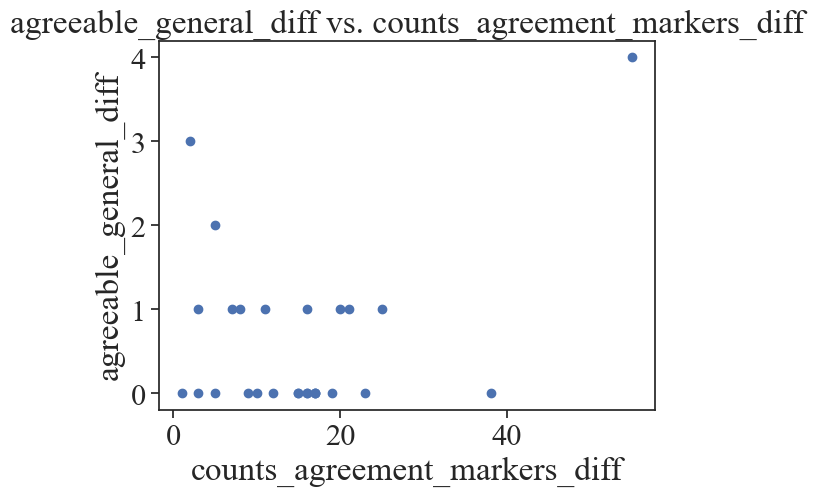

In [ ]:
#plot agreeable_general_diff vs. counts_agreement_markers_diff
plt.scatter(df_turns_diff['counts_agreement_markers_diff'], df_turns_diff['agreeable_general_diff'])
plt.xlabel('counts_agreement_markers_diff')
plt.ylabel('agreeable_general_diff')
plt.title('agreeable_general_diff vs. counts_agreement_markers_diff')
plt.show()


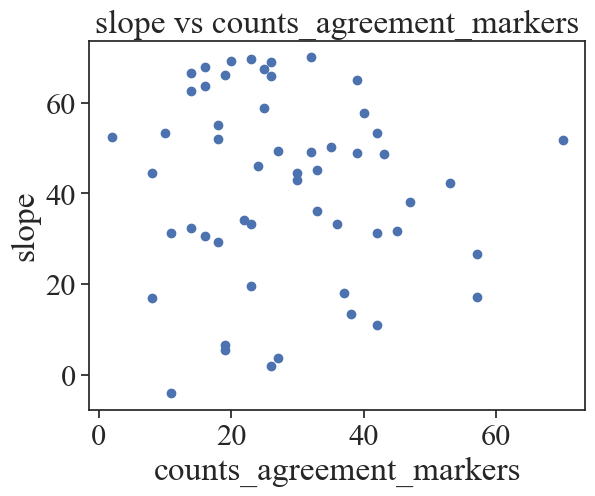

In [ ]:
#plot slope vs counts_agreement_markers
plt.scatter(df_turns['counts_agreement_markers'], df_turns['slope'])
plt.xlabel('counts_agreement_markers')
plt.ylabel('slope')
plt.title('slope vs counts_agreement_markers')
plt.show()

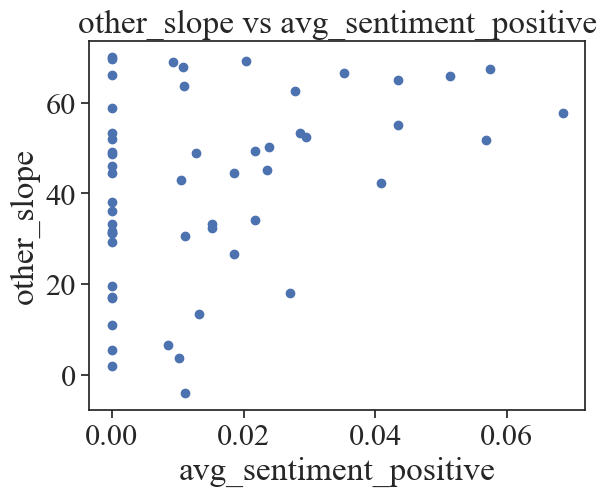

In [ ]:
#plot other_slope vs avg_sentiment_positive
plt.scatter(df_turns['avg_sentiment_positive'], df_turns['other_slope'])
plt.xlabel('avg_sentiment_positive')
plt.ylabel('other_slope')
plt.title('other_slope vs avg_sentiment_positive')
plt.show()


<AxesSubplot: xlabel='agreeableness', ylabel='other_slope'>

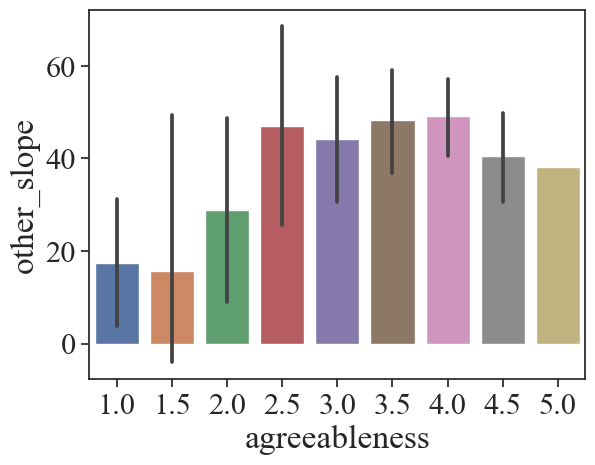

In [ ]:
#barplot with agreeableness and other_slope
sns.barplot(x = 'agreeableness', y = 'other_slope', data = df_turns)

<AxesSubplot: xlabel='agreeableness', ylabel='other_agreeable'>

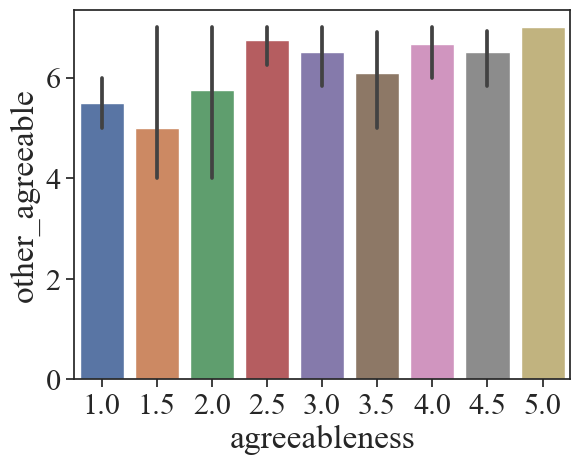

In [ ]:
#barplot with agreeableness and other_slope
sns.barplot(x = 'agreeableness', y = 'other_agreeable', data = df_turns)

<AxesSubplot: xlabel='neuroticism', ylabel='other_agreeable'>

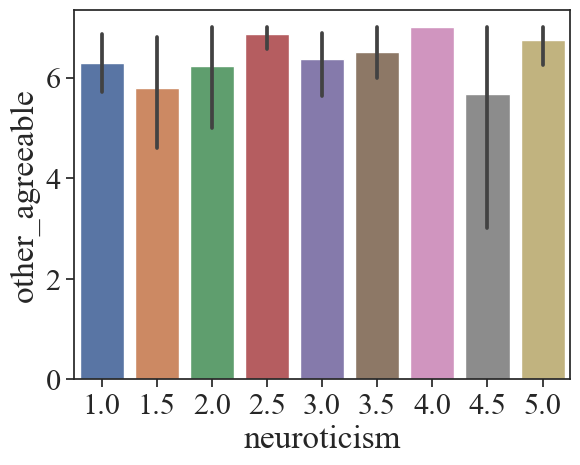

In [ ]:
#barplot with agreeableness and other_slope
sns.barplot(x = 'neuroticism', y = 'other_agreeable', data = df_turns)

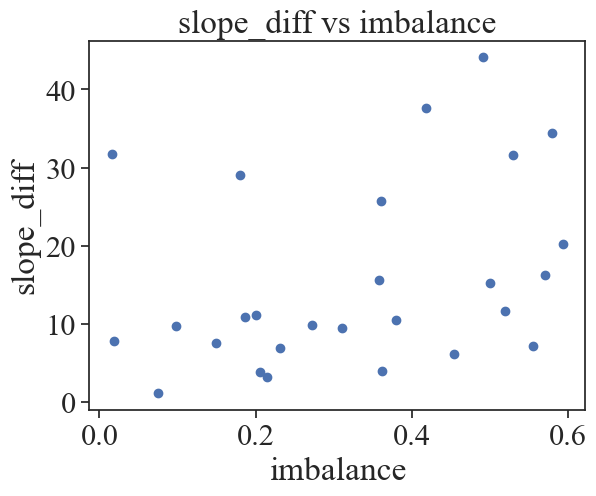

In [ ]:
#plot slope_diff vs imbalance
plt.scatter(df_turns_diff['imbalance'], df_turns_diff['slope_diff'])
plt.xlabel('imbalance')
plt.ylabel('slope_diff')
plt.title('slope_diff vs imbalance')
plt.show()


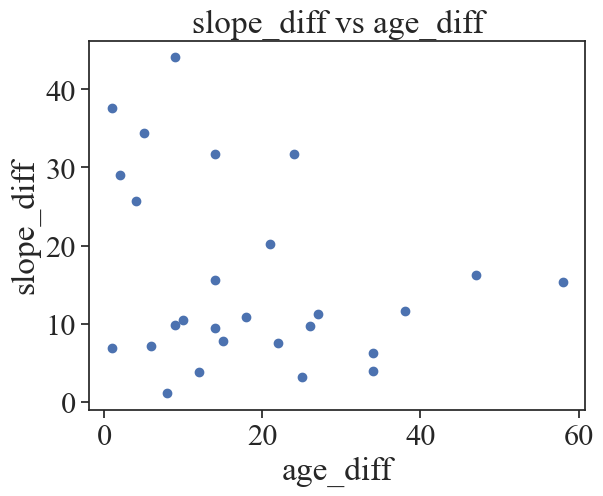

In [ ]:
#plot slope_diff vs age_diff
plt.scatter(df_turns_diff['age_diff'], df_turns_diff['slope_diff'])
plt.xlabel('age_diff')
plt.ylabel('slope_diff')
plt.title('slope_diff vs age_diff')
plt.show()

<AxesSubplot: xlabel='imbalance_cat', ylabel='slope_diff'>

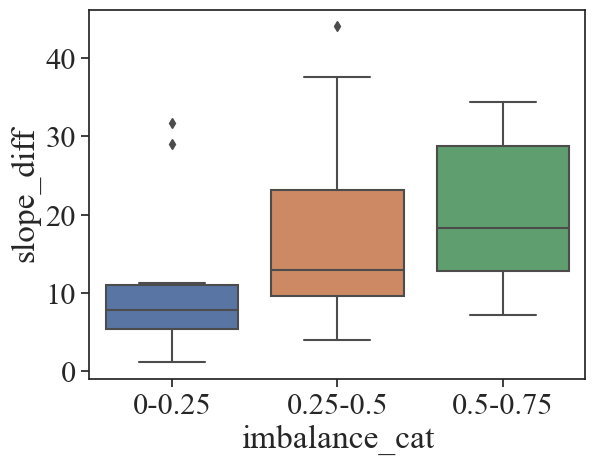

In [ ]:
#plot whisker plots, while grouping by imbalance (0,0.25,0.5,0.75)
#get categories of imbalance, slip into 4 classes
imbalance_cat = []
for ind, row in df_turns_diff.iterrows():
    imb = row['imbalance']
    if imb < 0.25:
        imbalance_cat.append('0-0.25')
    elif imb < 0.5:
        imbalance_cat.append('0.25-0.5')
    elif imb < 0.75:
        imbalance_cat.append('0.5-0.75')
    else:
        imbalance_cat.append('>0.75')


#add imbalance_cat to df_turns_diff
df_turns_diff['imbalance_cat'] = imbalance_cat

df_turns_sorted = df_turns_diff.sort_values(by = ['imbalance_cat'])

sns.boxplot(x = 'imbalance_cat', y = 'slope_diff', data = df_turns_sorted)


<AxesSubplot: xlabel='avg_sentiment_positive_cat', ylabel='slope'>

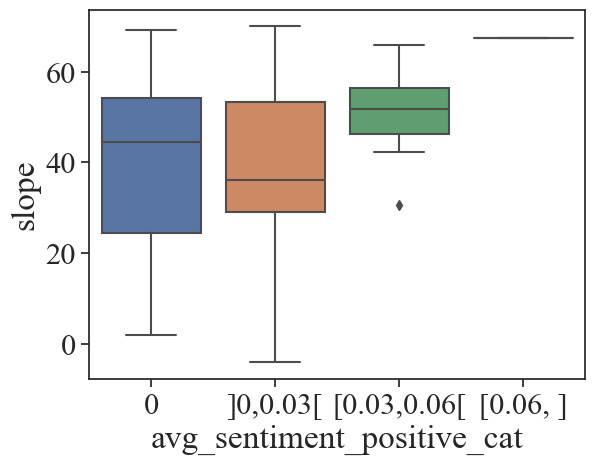

In [ ]:
#now, do the same for other_slope vs avg_sentiment_positive
#categorize avg_sentiment_positive
avg_sentiment_positive_cat = []
#sort df_turns by avg_sentiment_positive
df_turns = df_turns.sort_values(by = ['avg_sentiment_positive'])

for ind, row in df_turns.iterrows():
    avg_sent = row['avg_sentiment_positive']
    if avg_sent == 0:
        avg_sentiment_positive_cat.append('0')
    elif avg_sent < 0.03:
        avg_sentiment_positive_cat.append(']0,0.03[')
    elif avg_sent < 0.06:
        avg_sentiment_positive_cat.append('[0.03,0.06[')
    else:
        avg_sentiment_positive_cat.append('[0.06, ]')




#add imbalance_cat to df_turns_diff
df_turns['avg_sentiment_positive_cat'] = avg_sentiment_positive_cat

#sort df by this order: [0, ']0,0.03[','[0.03,0.06[', '[0.06, ]']

#df_turns_sorted = df_turns.sort_values(by = ['avg_sentiment_positive_cat'])

sns.boxplot(x = 'avg_sentiment_positive_cat', y = 'slope', data = df_turns)


<AxesSubplot: xlabel='age_diff_cat', ylabel='slope_diff'>

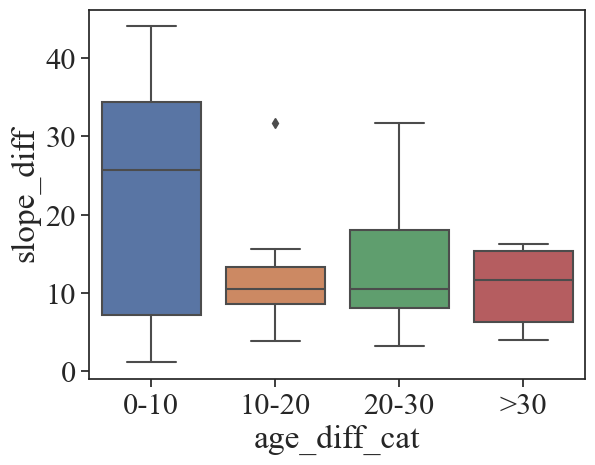

In [ ]:
#now, do the same for age_diff vs slope_diff
#categorize age_diff
age_diff_cat = []
#sort df_turns by avg_sentiment_positive
df_turns_diff = df_turns_diff.sort_values(by = ['age_diff'])

age_diff_cat = []
for ind, row in df_turns_diff.iterrows():
    age_diff = row['age_diff']
    if age_diff <10:
        age_diff_cat.append('0-10')
    elif age_diff < 20:
        age_diff_cat.append('10-20')
    elif age_diff < 30:
        age_diff_cat.append('20-30')
    else:
        age_diff_cat.append('>30')



#add imbalance_cat to df_turns_diff
df_turns_diff['age_diff_cat'] = age_diff_cat

#sort df by this order: [0, ']0,0.03[','[0.03,0.06[', '[0.06, ]']

#df_turns_sorted = df_turns.sort_values(by = ['avg_sentiment_positive_cat'])

sns.boxplot(x = 'age_diff_cat', y = 'slope_diff', data = df_turns_diff)


# PCA

In [1]:
#imports for standartizing dataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
#import libraries for running pca analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#immpot pca
from sklearn.decomposition import PCA

In [3]:
#open data
df = pd.read_csv('../data/all_data_05_norm.csv')
#df_norm = pd.read_csv('../../data/pair_features_overlap_high_discomfort_10hz_normalized.csv')
print(df.shape)
#get columns
cols = df.columns
#print(cols)
#get features, anything from column 5 to the end, excluding cols 6 and 7, adn 124 and 125
features = cols[5:]
features = [f for f in features if f not in ['s2','s3','s120','s121']]

#remove sessions with "_1"
sessions = df['session'].values
sessions = [s for s in sessions if '_1' not in s]
df = df[df['session'].isin(sessions)]
print(df.shape)


#features = [f for f in features if 'r' in f]
print(features)
print(len(features))
classes = cols[2]
participant_col = cols[0]

#we can do all, or participant by participant

#reindex
df = df.reset_index(drop=True)



(60808, 242)
(30404, 242)
['s1', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54', 's55', 's56', 's57', 's58', 's59', 's60', 's61', 's62', 's63', 's64', 's65', 's66', 's67', 's68', 's69', 's70', 's71', 's72', 's73', 's74', 's75', 's76', 's77', 's78', 's79', 's80', 's81', 's82', 's83', 's84', 's85', 's86', 's87', 's88', 's89', 's90', 's91', 's92', 's93', 's94', 's95', 's96', 's97', 's98', 's99', 's100', 's101', 's102', 's103', 's104', 's105', 's106', 's107', 's108', 's109', 's110', 's111', 's112', 's113', 's114', 's115', 's116', 's117', 's118', 's119', 's122', 's123', 's124', 's125', 's126', 's127', 's128', 's129', 's130', 's131', 's132', 's133', 's134', 's135', 's136', 's137', 's138', 's139

[[ 2.61671159 -1.3936707  -1.38928532 ...  0.17074858 -0.09808915
   0.34990399]
 [ 2.61671159 -1.3936707  -1.38928532 ...  0.55246374 -0.01405457
   0.42864023]
 [ 2.61671159 -1.3936707  -1.38928532 ...  0.01569116 -0.5927223
  -0.27576176]
 ...
 [-0.77930045  1.95920292  1.1346133  ...  0.34741936  0.0191763
   0.5277764 ]
 [-0.77610502  1.9646068   1.1346133  ...  0.36038411  0.0301599
   0.52973553]
 [-0.77291319  1.97001475  1.1346133  ...  0.36503147  0.03337501
   0.53151378]]
(30404, 233)


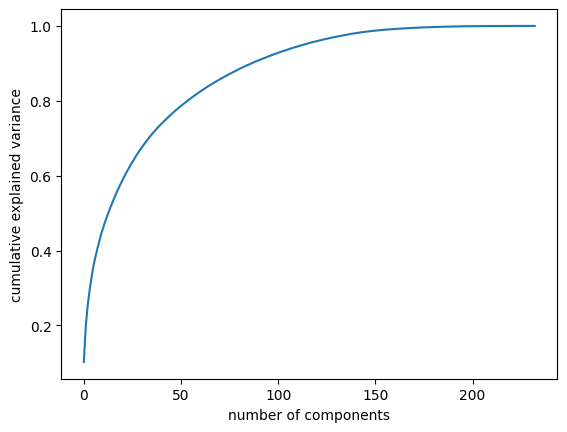

number of components:
(30404, 88)
  session  timeelapsed  groundtruth  value_p0  value_p1  \
0  1011_0     0.000000          0.0       0.0       0.0   
1  1011_0     0.500817          0.0       0.0       0.0   
2  1011_0     1.001735          0.0       0.0       0.0   
3  1011_0     1.502701          0.0       0.0       0.0   
4  1011_0     2.003673          0.0       0.0       0.0   

   principal_component_0  principal_component_1  principal_component_2  \
0               0.112422              -2.957818               3.549492   
1               1.442360              -1.983403              -0.480610   
2               0.746618              -2.711767              -0.643075   
3               1.877694              -1.199523              -0.012678   
4               1.449439              -1.690573              -0.138312   

   principal_component_3  principal_component_4  ...  principal_component_78  \
0              -2.380109              -0.779550  ...               -0.240773   
1     

In [4]:
#now, run PCA analysis on the data, leave only feature that explain 95% of the variance


x = df[features].values
print(x)


#run PCA analysiS
pca = PCA()
principalComponents = pca.fit_transform(x)

print(principalComponents.shape)

#plot the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#keep only the features that explain 90% of the variance
pca = PCA(n_components=0.90)
principalComponents = pca.fit_transform(x)
print('number of components:')
print(principalComponents.shape)


#save the principal components to a file
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal_component_' + str(i) for i in range(principalComponents.shape[1])])

#add the initial columns to the principal components
principalDf = pd.concat([df.iloc[:,:5], principalDf], axis = 1)
print(principalDf.head())

#save as csv
principalDf.to_csv('../data/all_data_05_pca.csv', index = False)


In [6]:
#open data
df = pd.read_csv('../data/all_data_05_norm_sign.csv')
#df_norm = pd.read_csv('../../data/pair_features_overlap_high_discomfort_10hz_normalized.csv')
print(df.shape)
#get columns
cols = df.columns
#print(cols)
#get features, anything from column 5 to the end, excluding cols 6 and 7, adn 124 and 125
features = cols[5:]
features = [f for f in features if f not in ['s2','s3','s120','s121']]

#remove sessions with "_1"
sessions = df['session'].values
sessions = [s for s in sessions if '_1' not in s]
df = df[df['session'].isin(sessions)]
print(df.shape)


#features = [f for f in features if 'r' in f]
print(features)
print(len(features))
classes = cols[2]
participant_col = cols[0]

#we can do all, or participant by participant

#reindex
df = df.reset_index(drop=True)



(4090, 242)
(1593, 242)
['s1', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54', 's55', 's56', 's57', 's58', 's59', 's60', 's61', 's62', 's63', 's64', 's65', 's66', 's67', 's68', 's69', 's70', 's71', 's72', 's73', 's74', 's75', 's76', 's77', 's78', 's79', 's80', 's81', 's82', 's83', 's84', 's85', 's86', 's87', 's88', 's89', 's90', 's91', 's92', 's93', 's94', 's95', 's96', 's97', 's98', 's99', 's100', 's101', 's102', 's103', 's104', 's105', 's106', 's107', 's108', 's109', 's110', 's111', 's112', 's113', 's114', 's115', 's116', 's117', 's118', 's119', 's122', 's123', 's124', 's125', 's126', 's127', 's128', 's129', 's130', 's131', 's132', 's133', 's134', 's135', 's136', 's137', 's138', 's139',

[[-0.71785706 -1.28375911 -1.07612663 ... -0.08821822 -0.48968804
  -0.06169484]
 [-0.71785706 -1.28375911 -1.06813453 ...  1.71739185 -0.74049626
   0.27168926]
 [-0.71785706 -1.28375911 -0.97603676 ...  2.1094794  -0.34933621
  -0.05238797]
 ...
 [-0.90101351  0.64887294  0.27085312 ... -0.09228473  0.54061344
  -0.00215695]
 [-0.90354161  0.71329401 -0.18124874 ...  0.36782956 -0.02122432
   0.66844308]
 [-0.90014122  0.71329401 -0.12979013 ...  0.84215844  0.45453631
  -0.25233975]]
(1593, 233)


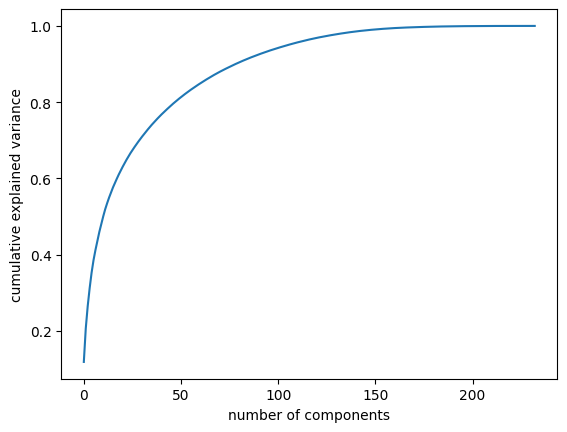

number of components:
(1593, 80)
  session  timeelapsed  groundtruth  derivative_sign_p0  derivative_sign_p1  \
0  1011_0     9.518395          1.0                 1.0                 0.0   
1  1011_0    10.019385          1.0                 1.0                 0.0   
2  1011_0    10.520490          1.0                 1.0                 0.0   
3  1011_0    12.525048          1.0                 1.0                 0.0   
4  1011_0    13.025722          1.0                 1.0                 0.0   

   principal_component_0  principal_component_1  principal_component_2  \
0              -1.334561              -1.027199               2.015152   
1              -1.386614               1.437060               0.661594   
2              -0.294562               0.358503              -0.711426   
3               3.221864              -3.021440               0.417485   
4              -0.528195              -3.707965               0.688542   

   principal_component_3  principal_component_4

In [7]:
#now, run PCA analysis on the data, leave only feature that explain 95% of the variance


x = df[features].values
print(x)


#run PCA analysiS
pca = PCA()
principalComponents = pca.fit_transform(x)

print(principalComponents.shape)

#plot the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#keep only the features that explain 90% of the variance
pca = PCA(n_components=0.90)
principalComponents = pca.fit_transform(x)
print('number of components:')
print(principalComponents.shape)


#save the principal components to a file
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal_component_' + str(i) for i in range(principalComponents.shape[1])])

#add the initial columns to the principal components
principalDf = pd.concat([df.iloc[:,:5], principalDf], axis = 1)
print(principalDf.head())

#save as csv
principalDf.to_csv('../data/all_data_05_pca_sign.csv', index = False)
